# Dissecting Spotify Valence

This is the third assignment for the course "Applied Machine Learning".

> Nikolas Moatsos <br />
>Department of Management Science and Technology <br />
>Athens University of Economics and Business

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

The task of this assignment is to untangle the mystery behind valence.

This notebook demonstrates the analysis of the valence metric and also implements machine learning models that try to predict it.


* First of all, we have to import all the necessary libraries for our task.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

import librosa
import librosa.display

## Q1: Expore which Features Influence Valence

* In this section we will use inferential statistic methods to study how track and audio features influence the valence metric. 
* Also, we will use the variables that found significant to create models for explaining the valence. 

### Track and high level audio features

* From the **data_collection.ipynb** notebook we have acquired all the necessary data for our analysis.
* To start with, we import the DataFrame that contains only track and high level audio features.

In [2]:
tracks = pd.read_csv('data/tracks.csv',index_col=0)
tracks

danceability  energy  key  loudness  mode  \
4a2qoYY6xINDXtUOBFbJ6d         0.122  0.0182    2   -27.890     1   
238ByVSDcz260ewWOEgAQf         0.415  0.1320    0   -17.186     1   
533Q9BiC93uzp3AnvMNLmc         0.769  0.4360    7    -5.716     1   
3DytidwwDXv5gZVilj2lO1         0.559  0.7200    0    -5.948     1   
1Xkpw8X6WVmkditTPZ7YSk         0.481  0.3870    2   -16.633     1   
...                              ...     ...  ...       ...   ...   
4K87CebUVshxBCfwv4Gjs8         0.704  0.2350    9   -17.272     1   
36PNa2n55qLfQd7KLXyeoy         0.723  0.7240    0    -6.378     1   
0ukMJRQa8UoAbtNVIhEgYE         0.543  0.5640    2   -10.260     1   
2iguaRelnM3P06EOcBjsv9         0.497  0.6540    0    -9.714     1   
6M33HiUHLC3R3gfXYNGMAy         0.955  0.7680    1    -5.540     0   

                        speechiness  acousticness  instrumentalness  liveness  \
4a2qoYY6xINDXtUOBFbJ6d       0.0383      0.967000          0.834000    0.0735   
238ByVSDcz260ewWOEgAQf       0.0436      0.981000          0.179000    0.1650   
533Q9BiC93uzp3AnvMNLmc       0.0505      0.715000          0.000000    0.1700   
3DytidwwDXv5gZVilj2lO1       0.0302      0.111000          0.000105    0.3280   
1Xkpw8X6WVmkditTPZ7YSk       0.0416      0.901000          0.820000    0.1560   
...                             ...           ...               ...       ...   
4K87CebUVshxBCfwv4Gjs8       0.9530      0.750000          0.000000    0.3700   
36PNa2n55qLfQd7KLXyeoy       0.0304      0.294000          0.000000    0.1210   
0ukMJRQa8UoAbtNVIhEgYE       0.0404      0.047100          0.000000    0.0936   
2iguaRelnM3P06EOcBjsv9       0.0296      0.000507          0.390000    0.2030   
6M33HiUHLC3R3gfXYNGMAy       0.1810      0.013400          0.000000    0.3080   

                        valence    tempo  duration_ms  time_signature  \
4a2qoYY6xINDXtUOBFbJ6d   0.0473   77.590       477733               3   
238ByVSDcz260ewWOEgAQf   0.4180   92.253       200040               4   
533Q9BiC93uzp3AnvMNLmc   0.9710  119.675       297494               3   
3DytidwwDXv5gZVilj2lO1   0.6830  125.139       228133               4   
1Xkpw8X6WVmkditTPZ7YSk   0.7400  110.564       112039               4   
...                         ...      ...          ...             ...   
4K87CebUVshxBCfwv4Gjs8   0.4010  131.762       329497               4   
36PNa2n55qLfQd7KLXyeoy   0.9270  117.990       251787               4   
0ukMJRQa8UoAbtNVIhEgYE   0.8460   92.839       103173               4   
2iguaRelnM3P06EOcBjsv9   0.8300  144.099       125453               3   
6M33HiUHLC3R3gfXYNGMAy   0.7410  125.040       194293               4   

                        explicit  year  
4a2qoYY6xINDXtUOBFbJ6d         0  1985  
238ByVSDcz260ewWOEgAQf         0  1949  
533Q9BiC93uzp3AnvMNLmc         0  2004  
3DytidwwDXv5gZVilj2lO1         0  1979  
1Xkpw8X6WVmkditTPZ7YSk         0  1959  
...                          ...   ...  
4K87CebUVshxBCfwv4Gjs8         0  1935  
36PNa2n55qLfQd7KLXyeoy         0  2008  
0ukMJRQa8UoAbtNVIhEgYE         0  1968  
2iguaRelnM3P06EOcBjsv9         0  1947  
6M33HiUHLC3R3gfXYNGMAy         1  2000  

[132845 rows x 15 columns]

* Because the key is a categorical variable we create dummies.

In [3]:
key_dummies = dummies = pd.get_dummies(data=tracks['key'])
key_dummies = key_dummies.add_prefix('key_')

tracks_dummies = tracks.join(key_dummies)
tracks_dummies.drop(columns='key',inplace=True)
tracks_dummies

danceability  energy  loudness  mode  speechiness  \
4a2qoYY6xINDXtUOBFbJ6d         0.122  0.0182   -27.890     1       0.0383   
238ByVSDcz260ewWOEgAQf         0.415  0.1320   -17.186     1       0.0436   
533Q9BiC93uzp3AnvMNLmc         0.769  0.4360    -5.716     1       0.0505   
3DytidwwDXv5gZVilj2lO1         0.559  0.7200    -5.948     1       0.0302   
1Xkpw8X6WVmkditTPZ7YSk         0.481  0.3870   -16.633     1       0.0416   
...                              ...     ...       ...   ...          ...   
4K87CebUVshxBCfwv4Gjs8         0.704  0.2350   -17.272     1       0.9530   
36PNa2n55qLfQd7KLXyeoy         0.723  0.7240    -6.378     1       0.0304   
0ukMJRQa8UoAbtNVIhEgYE         0.543  0.5640   -10.260     1       0.0404   
2iguaRelnM3P06EOcBjsv9         0.497  0.6540    -9.714     1       0.0296   
6M33HiUHLC3R3gfXYNGMAy         0.955  0.7680    -5.540     0       0.1810   

                        acousticness  instrumentalness  liveness  valence  \
4a2qoYY6xINDXtUOBFbJ6d      0.967000          0.834000    0.0735   0.0473   
238ByVSDcz260ewWOEgAQf      0.981000          0.179000    0.1650   0.4180   
533Q9BiC93uzp3AnvMNLmc      0.715000          0.000000    0.1700   0.9710   
3DytidwwDXv5gZVilj2lO1      0.111000          0.000105    0.3280   0.6830   
1Xkpw8X6WVmkditTPZ7YSk      0.901000          0.820000    0.1560   0.7400   
...                              ...               ...       ...      ...   
4K87CebUVshxBCfwv4Gjs8      0.750000          0.000000    0.3700   0.4010   
36PNa2n55qLfQd7KLXyeoy      0.294000          0.000000    0.1210   0.9270   
0ukMJRQa8UoAbtNVIhEgYE      0.047100          0.000000    0.0936   0.8460   
2iguaRelnM3P06EOcBjsv9      0.000507          0.390000    0.2030   0.8300   
6M33HiUHLC3R3gfXYNGMAy      0.013400          0.000000    0.3080   0.7410   

                          tempo  ...  key_2  key_3  key_4  key_5  key_6  \
4a2qoYY6xINDXtUOBFbJ6d   77.590  ...      1      0      0      0      0   
238ByVSDcz260ewWOEgAQf   92.253  ...      0      0      0      0      0   
533Q9BiC93uzp3AnvMNLmc  119.675  ...      0      0      0      0      0   
3DytidwwDXv5gZVilj2lO1  125.139  ...      0      0      0      0      0   
1Xkpw8X6WVmkditTPZ7YSk  110.564  ...      1      0      0      0      0   
...                         ...  ...    ...    ...    ...    ...    ...   
4K87CebUVshxBCfwv4Gjs8  131.762  ...      0      0      0      0      0   
36PNa2n55qLfQd7KLXyeoy  117.990  ...      0      0      0      0      0   
0ukMJRQa8UoAbtNVIhEgYE   92.839  ...      1      0      0      0      0   
2iguaRelnM3P06EOcBjsv9  144.099  ...      0      0      0      0      0   
6M33HiUHLC3R3gfXYNGMAy  125.040  ...      0      0      0      0      0   

                        key_7  key_8  key_9  key_10  key_11  
4a2qoYY6xINDXtUOBFbJ6d      0      0      0       0       0  
238ByVSDcz260ewWOEgAQf      0      0      0       0       0  
533Q9BiC93uzp3AnvMNLmc      1      0      0       0       0  
3DytidwwDXv5gZVilj2lO1      0      0      0       0       0  
1Xkpw8X6WVmkditTPZ7YSk      0      0      0       0       0  
...                       ...    ...    ...     ...     ...  
4K87CebUVshxBCfwv4Gjs8      0      0      1       0       0  
36PNa2n55qLfQd7KLXyeoy      0      0      0       0       0  
0ukMJRQa8UoAbtNVIhEgYE      0      0      0       0       0  
2iguaRelnM3P06EOcBjsv9      0      0      0       0       0  
6M33HiUHLC3R3gfXYNGMAy      0      0      0       0       0  

[132845 rows x 26 columns]

* We can also see that there are differences in the variances of the variables.
* This indicates that we will need to standardize our *X_train* values for the models that use distances.

In [4]:
tracks.describe()

danceability         energy            key       loudness  \
count  132845.000000  132845.000000  132845.000000  132845.000000   
mean        0.538428       0.488757       5.206572     -11.438575   
std         0.177085       0.268036       3.516391       5.726618   
min         0.000000       0.000000       0.000000     -60.000000   
25%         0.416000       0.263000       2.000000     -14.560000   
50%         0.549000       0.481000       5.000000     -10.498000   
75%         0.670000       0.711000       8.000000      -7.143000   
max         0.988000       1.000000      11.000000       3.855000   

                mode    speechiness   acousticness  instrumentalness  \
count  132845.000000  132845.000000  132845.000000     132845.000000   
mean        0.707283       0.101848       0.495724          0.165865   
std         0.455011       0.164104       0.378652          0.311902   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.035400       0.094800          0.000000   
50%         1.000000       0.046200       0.495000          0.000233   
75%         1.000000       0.080500       0.896000          0.102000   
max         1.000000       0.969000       0.996000          1.000000   

            liveness        valence          tempo   duration_ms  \
count  132845.000000  132845.000000  132845.000000  1.328450e+05   
mean        0.211730       0.535494     116.924964  2.313684e+05   
std         0.182039       0.262923      30.825851  1.269159e+05   
min         0.000000       0.000000       0.000000  5.991000e+03   
25%         0.099200       0.327000      93.407000  1.700670e+05   
50%         0.138000       0.550000     114.795000  2.077330e+05   
75%         0.271000       0.753000     135.770000  2.630670e+05   
max         1.000000       1.000000     244.080000  5.403500e+06   

       time_signature       explicit           year  
count   132845.000000  132845.000000  132845.000000  
mean         3.848048       0.091257    1976.802785  
std          0.517618       0.287975      25.864054  
min          0.000000       0.000000    1900.000000  
25%          4.000000       0.000000    1955.000000  
50%          4.000000       0.000000    1978.000000  
75%          4.000000       0.000000    1999.000000  
max          5.000000       1.000000    2021.000000

* Moreover, we perform standardization to the data to use it later in the regression.

In [5]:
scaler = StandardScaler()
tracks_std = tracks_dummies.copy()
tracks_std = scaler.fit_transform(tracks_std)
tracks_std = pd.DataFrame(tracks_std,columns=tracks_dummies.columns, index=tracks_dummies.index)
tracks_std.describe()

danceability        energy      loudness          mode   speechiness  \
count  1.328450e+05  1.328450e+05  1.328450e+05  1.328450e+05  1.328450e+05   
mean  -8.932262e-17  4.102422e-17  3.004877e-16 -4.426016e-17  1.164938e-16   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -3.040518e+00 -1.823486e+00 -8.479981e+00 -1.554435e+00 -6.206315e-01   
25%   -6.913549e-01 -8.422697e-01 -5.450752e-01 -1.554435e+00 -4.049145e-01   
50%    5.969961e-02 -2.894194e-02  1.642467e-01  6.433206e-01 -3.391025e-01   
75%    7.429898e-01  8.291562e-01  7.501096e-01  6.433206e-01 -1.300886e-01   
max    2.538744e+00  1.907375e+00  2.670622e+00  6.433206e-01  5.284165e+00   

       acousticness  instrumentalness      liveness       valence  \
count  1.328450e+05      1.328450e+05  1.328450e+05  1.328450e+05   
mean  -9.533986e-17     -6.097472e-18  1.645248e-16  1.591761e-16   
std    1.000004e+00      1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.309187e+00     -5.317860e-01 -1.163108e+00 -2.036702e+00   
25%   -1.058824e+00     -5.317860e-01 -6.181664e-01 -7.929885e-01   
50%   -1.913116e-03     -5.310390e-01 -4.050239e-01  5.517110e-02   
75%    1.057111e+00     -2.047594e-01  3.255935e-01  8.272626e-01   
max    1.321207e+00      2.674357e+00  4.330256e+00  1.766704e+00   

              tempo  ...         key_2         key_3         key_4  \
count  1.328450e+05  ...  1.328450e+05  1.328450e+05  1.328450e+05   
mean  -2.549305e-16  ... -3.107571e-17 -3.829641e-17  7.648584e-18   
std    1.000004e+00  ...  1.000004e+00  1.000004e+00  1.000004e+00   
min   -3.793096e+00  ... -3.557920e-01 -2.093932e-01 -2.891363e-01   
25%   -7.629328e-01  ... -3.557920e-01 -2.093932e-01 -2.891363e-01   
50%   -6.909694e-02  ... -3.557920e-01 -2.093932e-01 -2.891363e-01   
75%    6.113410e-01  ... -3.557920e-01 -2.093932e-01 -2.891363e-01   
max    4.124964e+00  ...  2.810631e+00  4.775704e+00  3.458577e+00   

              key_5         key_6         key_7         key_8         key_9  \
count  1.328450e+05  1.328450e+05  1.328450e+05  1.328450e+05  1.328450e+05   
mean   4.161257e-17 -2.872230e-17 -6.843610e-17 -2.551311e-17  3.241288e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -3.227835e-01 -2.323952e-01 -3.733901e-01 -2.562894e-01 -3.415330e-01   
25%   -3.227835e-01 -2.323952e-01 -3.733901e-01 -2.562894e-01 -3.415330e-01   
50%   -3.227835e-01 -2.323952e-01 -3.733901e-01 -2.562894e-01 -3.415330e-01   
75%   -3.227835e-01 -2.323952e-01 -3.733901e-01 -2.562894e-01 -3.415330e-01   
max    3.098052e+00  4.303015e+00  2.678164e+00  3.901840e+00  2.927974e+00   

             key_10        key_11  
count  1.328450e+05  1.328450e+05  
mean  -1.527042e-17 -5.851434e-17  
std    1.000004e+00  1.000004e+00  
min   -2.749040e-01 -2.607797e-01  
25%   -2.749040e-01 -2.607797e-01  
50%   -2.749040e-01 -2.607797e-01  
75%   -2.749040e-01 -2.607797e-01  
max    3.637633e+00  3.834654e+00  

[8 rows x 26 columns]

* We also display the distribution of the valence and we see that most of the values lie in the middle.

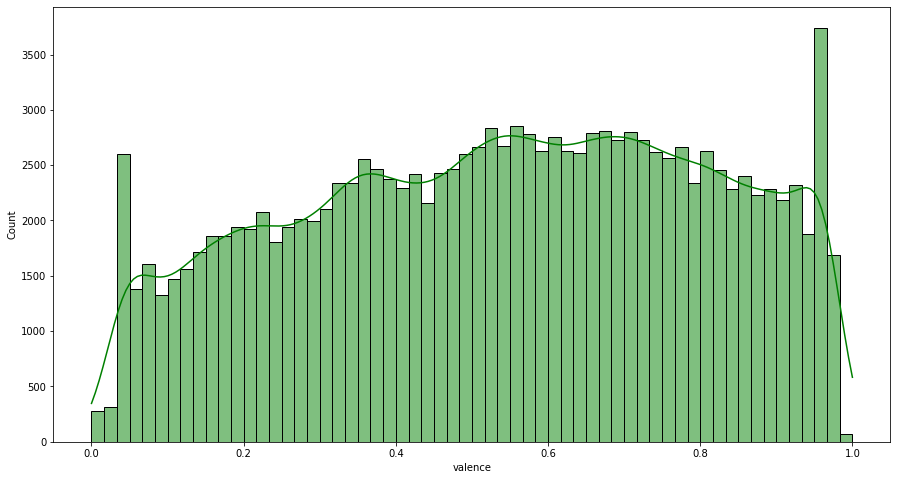

In [6]:
plt.figure(figsize=(15,8))
sns.histplot(x='valence', data=tracks, kde=True, color='g');

* To see how our variables are correlated, we create a heatmap with pair correlations.
* The `corr()` function calculates the *pearson corellation* between two variables.

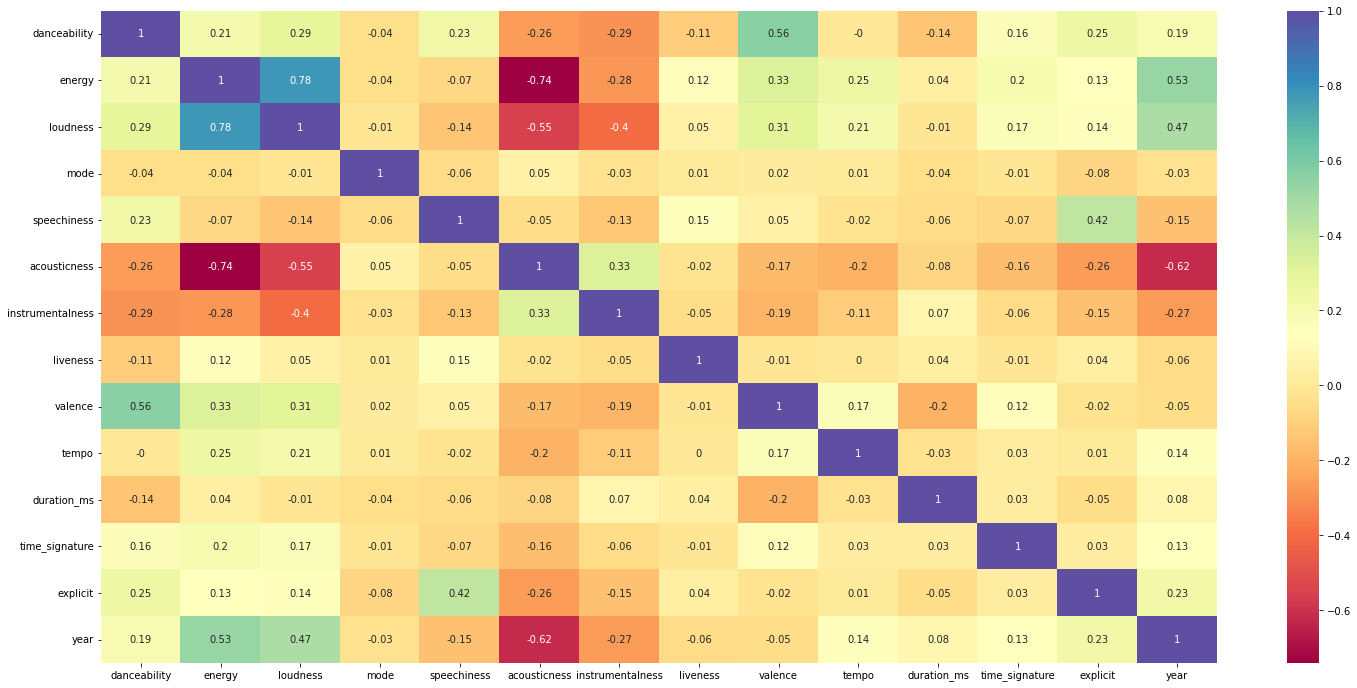

In [7]:
plt.figure(figsize=(25,12))
cor = round(tracks.loc[:,tracks.columns != 'key'].corr(),2)
sns.heatmap(cor, annot=True, cmap="Spectral")
plt.show()

* For the valence we notice that:
    * *Valence* seems positive correlated with *danceability*, *energy* and *loudness*.
    * Also seems negative correlated with *acousticness*, *instrumentalness* and *duration*.
* For the other variables we notice that:
    * *Energy* and *loudness* are higly positive correlated.
    * *Accousticness* is higly negative correlated with *energy*.
    * *Year* is higly negative correlated with *acousticness*.

* In addition, we plot the top 3 positive correlated variables of valence.
* We notice a small linear correlation.

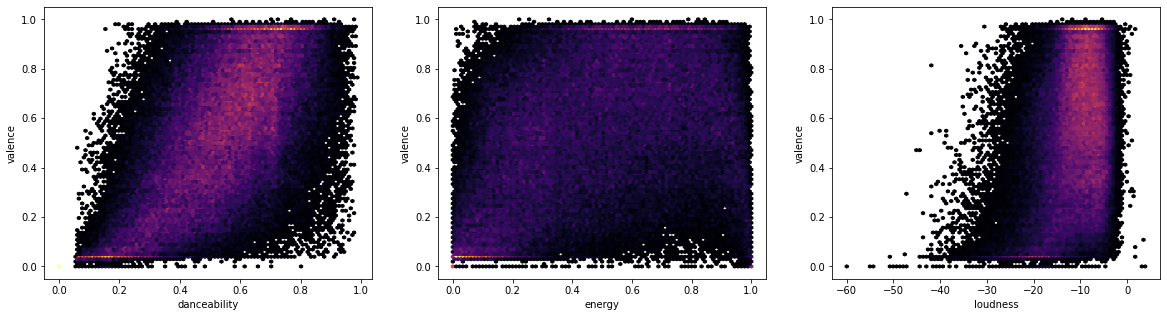

In [8]:
best_attributes = list(cor['valence'].sort_values(ascending=False)[1:4].index)

plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.4)

for i in range(len(best_attributes)):
  plt.subplot(1, 3, i + 1)
  plt.hexbin(tracks[best_attributes[i]], y=tracks['valence'], gridsize=90, mincnt=1, cmap="inferno")
  plt.xlabel(best_attributes[i])
  plt.ylabel('valence')

* We do the same thing for the top 3 negative correlated variables of valence.
* This time the linear correlation is even smaller and cannot be noticed.

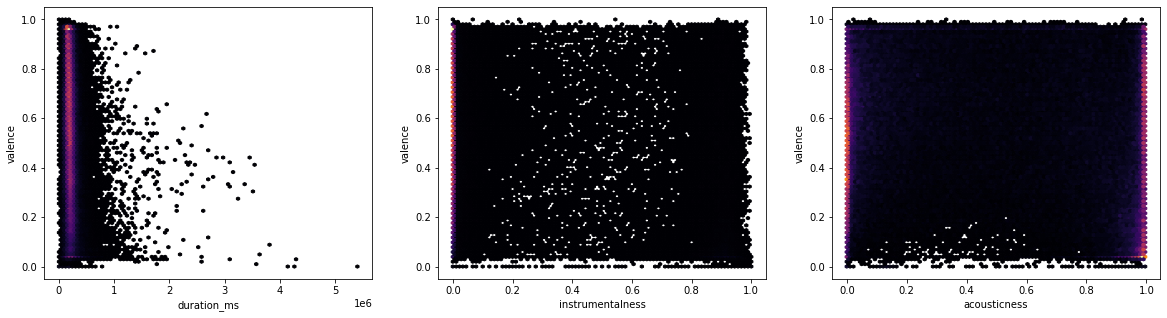

In [9]:
best_attributes = list(cor['valence'].sort_values()[0:3].index)

plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.4)

for i in range(len(best_attributes)):
  plt.subplot(1, 3, i + 1)
  plt.hexbin(tracks[best_attributes[i]], y=tracks['valence'], gridsize=90, mincnt=1, cmap="inferno")
  plt.xlabel(best_attributes[i])
  plt.ylabel('valence')

* We can also create boxplots for the year variable to see the trend.
* As we can see year tends to have a specific pattern regarding the valence, especially after 1960.

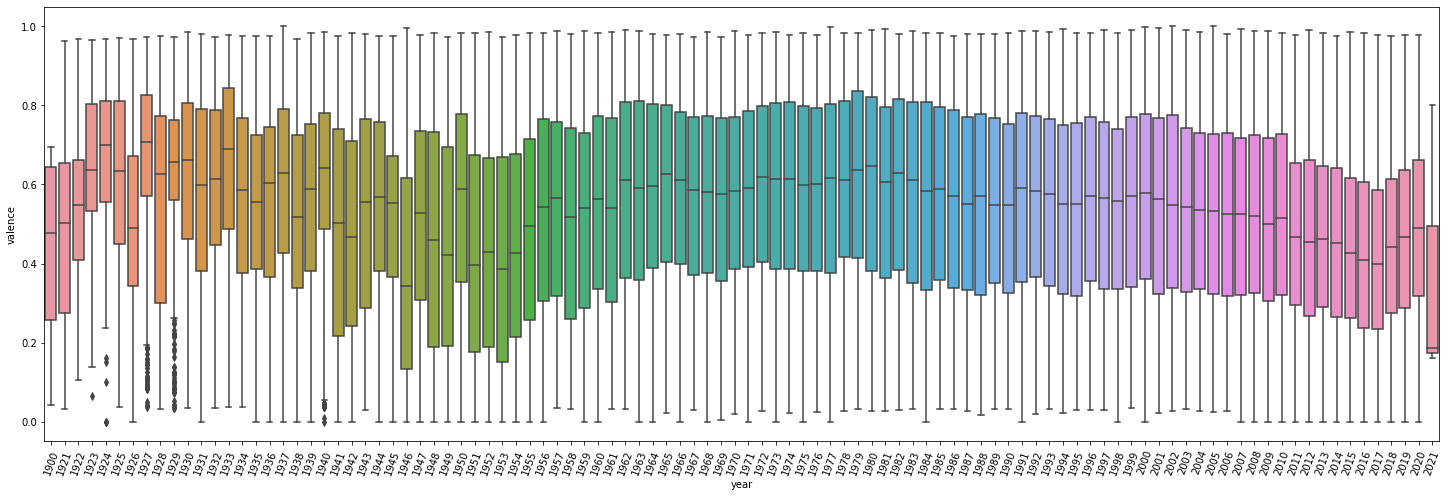

In [10]:
plt.figure(figsize=(25, 8))
plt.xticks(rotation=70)
sns.boxplot(x=tracks['year'], y=tracks['valence']);

* Moreover, since the key is a categorical variable we can again create boxplots to view its influence to the valence.

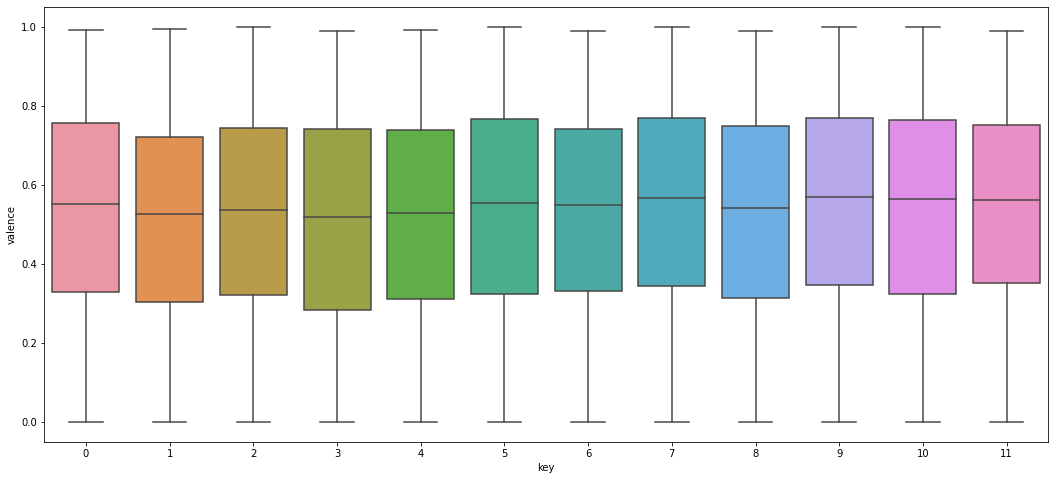

In [11]:
plt.figure(figsize=(18, 8))
sns.boxplot(x=tracks['key'], y=tracks['valence']);

* We cannnot notice a specific pattern from the boxplots.
* Also, because key is categorical and have more than two categories we can not calculate a correlation.
* Instead we can perform ANOVA to see if key has influence on the valence. 

In [12]:
key_model = smf.ols('valence ~ C(key)', data=tracks).fit()
sm.stats.anova_lm(key_model, typ=2)

sum_sq        df          F        PR(>F)
C(key)      21.665536      11.0  28.556751  1.098452e-60
Residual  9161.655177  132833.0        NaN           NaN

* We see that the p-value is smaller than 0.05 and we can conclude that the key variable has significant influence on the valence.

(*Idea obtained from: https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0*)

* Next, we calculate the VIF measure of the variables to see if there is strong multicollinearity between them.

In [13]:
C = add_constant(tracks_dummies.iloc[:, 0:-1])
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const               12335.114062
danceability            2.041758
energy                  4.862935
loudness                3.166601
mode                    1.071721
speechiness             1.544021
acousticness            3.011915
instrumentalness        1.354130
liveness                1.111423
valence                 2.052459
tempo                   1.111268
duration_ms             1.077396
time_signature          1.068772
explicit                1.442698
year                    2.061257
key_0                   2.681807
key_1                   2.050476
key_2                   2.523020
key_3                   1.635556
key_4                   2.058063
key_5                   2.290907
key_6                   1.717165
key_7                   2.645465
key_8                   1.892687
key_9                   2.404291
key_10                  1.981584
dtype: float64

* We do not notice multicolinearity since all the values are small.

* Now, we proceed to the creation of models that explain valence.
* In this case we use linear regression models.
* To evaluate the models we use the *Adjusted R-squared*, which bears in mind the number of variables that has been used.
* We use the standardized data, to be able to compare the different variables by their standardized coefficients.
* Because we can not compute every possible combination, we  perform forward stepwise selection and backward stepwise selection to find the best model.

*The following code was obtained from the notes of Professor Louridas.* 

In [14]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [15]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [16]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1
    
    for i in range(1, p):
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

* We perform the forward stepwise selection.

In [17]:
best_model_forward, best_models_forward = forward_stepwise_selection(tracks_std.loc[:,tracks_std.columns != 'key_0'], 'valence')
print('Best overall model:', len(best_model_forward.model.exog_names), best_model_forward.model.exog_names)

Fitted 326 models
Best overall model: 24 ['intercept', 'danceability', 'energy', 'year', 'explicit', 'tempo', 'duration_ms', 'acousticness', 'speechiness', 'key_1', 'loudness', 'instrumentalness', 'mode', 'key_7', 'key_5', 'key_9', 'key_10', 'key_6', 'key_4', 'time_signature', 'key_8', 'key_2', 'key_11', 'liveness']


* The best model has in total 24 variables including the intercept, which are almost all the variables, except key_3.
* We also plot the summary of the best model to see how the different variables affect the valence.  

In [18]:
best_model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     6078.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:26:29   Log-Likelihood:            -1.4074e+05
No. Observations:              132845   AIC:                         2.815e+05
Df Residuals:                  132821   BIC:                         2.818e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         1.535e-16      0.002   8.02e-14      1.000      -0.004       0.004
danceability         0.5821      0.002    261.963      0.000       0.578       0.586
energy               0.4822      0.004    120.213      0.000       0.474       0.490
year                -0.3126      0.003   -119.653      0.000      -0.318      -0.307
explicit            -0.1064      0.002    -46.638      0.000      -0.111      -0.102
tempo                0.1190      0.002     59.734      0.000       0.115       0.123
duration_ms         -0.1046      0.002    -53.169      0.000      -0.108      -0.101
acousticness         0.1088      0.003     32.892      0.000       0.102       0.115
speechiness         -0.0568      0.002    -23.927      0.000      -0.061      -0.052
key_1               -0.0299      0.002    -13.365      0.000      -0.034      -0.025
loudness            -0.0607      0.003    -17.835      0.000      -0.067      -0.054
instrumentalness    -0.0351      0.002    -15.764      0.000      -0.039      -0.031
mode                 0.0216      0.002     10.917      0.000       0.018       0.026
key_7                0.0058      0.002      2.473      0.013       0.001       0.010
key_5                0.0050      0.002      2.177      0.029       0.000       0.009
key_9                0.0024      0.002      1.016      0.310      -0.002       0.007
key_10               0.0021      0.002      0.945      0.345      -0.002       0.006
key_6               -0.0101      0.002     -4.700      0.000      -0.014      -0.006
key_4               -0.0104      0.002     -4.654      0.000      -0.015      -0.006
time_signature      -0.0052      0.002     -2.633      0.008      -0.009      -0.001
key_8               -0.0084      0.002     -3.886      0.000      -0.013      -0.004
key_2               -0.0088      0.002     -3.753      0.000      -0.013      -0.004
key_11              -0.0057      0.002     -2.561      0.010      -0.010      -0.001
liveness            -0.0048      0.002     -2.396      0.017      -0.009      -0.001
==============================================================================
Omnibus:                      269.394   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.987
Skew:                          -0.110   Prob(JB):                     1.43e-59
Kurtosis:                       3.013   Cond. No.                         5.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The best model achieved a 0.513 R-squared which means that the variables explain the 51.3% of the valence variation.
* Since the coefficients are standaridized we can notice that *danceability* has the biggest impact.
* Next in the line are *energy* and *year*, which also play an important role.
* Last, we see *explicit*, *tempo*, *duration* and *acousticness* follow with a smaller magnitude.
* All the important variables are statistically significant with p-values < 0.05.

* We perform the same procedure for backward stepwise selection.

In [19]:
def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [20]:
def backward_stepwise_selection(data, exog):

    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1

    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [21]:
best_model_backward, best_models_backward = backward_stepwise_selection(tracks_std.loc[:,tracks_std.columns != 'key_0'], 'valence')
print('Best overall model:', len(best_model_backward.model.exog_names), best_model_backward.model.exog_names)

Fitted 326 models
Best overall model: 22 ['intercept', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'time_signature', 'explicit', 'year', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_11']


* We see that this time the best model has 22 variables in total, excluding the variables key_3, key_9 and key_10.

In [22]:
best_model_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     6657.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:27:09   Log-Likelihood:            -1.4074e+05
No. Observations:              132845   AIC:                         2.815e+05
Df Residuals:                  132823   BIC:                         2.817e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         1.535e-16      0.002   8.02e-14      1.000      -0.004       0.004
danceability         0.5821      0.002    262.017      0.000       0.578       0.586
energy               0.4823      0.004    120.289      0.000       0.474       0.490
loudness            -0.0607      0.003    -17.847      0.000      -0.067      -0.054
mode                 0.0214      0.002     10.855      0.000       0.018       0.025
speechiness         -0.0568      0.002    -23.927      0.000      -0.061      -0.052
acousticness         0.1087      0.003     32.914      0.000       0.102       0.115
instrumentalness    -0.0351      0.002    -15.774      0.000      -0.039      -0.031
liveness            -0.0049      0.002     -2.407      0.016      -0.009      -0.001
tempo                0.1190      0.002     59.740      0.000       0.115       0.123
duration_ms         -0.1046      0.002    -53.173      0.000      -0.108      -0.101
time_signature      -0.0052      0.002     -2.630      0.009      -0.009      -0.001
explicit            -0.1064      0.002    -46.659      0.000      -0.111      -0.102
year                -0.3126      0.003   -119.654      0.000      -0.318      -0.307
key_1               -0.0309      0.002    -15.089      0.000      -0.035      -0.027
key_2               -0.0100      0.002     -4.820      0.000      -0.014      -0.006
key_4               -0.0115      0.002     -5.638      0.000      -0.016      -0.008
key_5                0.0038      0.002      1.839      0.066      -0.000       0.008
key_6               -0.0110      0.002     -5.475      0.000      -0.015      -0.007
key_7                0.0045      0.002      2.164      0.030       0.000       0.009
key_8               -0.0094      0.002     -4.657      0.000      -0.013      -0.005
key_11              -0.0067      0.002     -3.273      0.001      -0.011      -0.003
==============================================================================
Omnibus:                      269.058   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.647
Skew:                          -0.110   Prob(JB):                     1.70e-59
Kurtosis:                       3.012   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Again the model has achieved a 0.513 R-squared.
* We also see that the same variables as in forward stepwise selection are important and they are also statistically significant.

### Include low level audio features

* As mentioned in the `data_collection.ipynb` notebook to enrich the information about a track we include some low level audio features (pitches, timbre, loudeness attributes).
* We import the DataFrame that contains all the variables of the previous section as well as the mean values of the low level audio features for each track.
* Due to the difficulty of extracting low level audio features, the DataFrame contains a sample of the initial dataset (59,960 tracks).

In [23]:
low_level_tracks = pd.read_csv('data/low_level_tracks.csv',index_col=0)
low_level_tracks

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
238ByVSDcz260ewWOEgAQf  0.460020  0.201881  0.240555  0.169500  0.334406   
533Q9BiC93uzp3AnvMNLmc  0.360192  0.385989  0.551523  0.210450  0.270202   
3DytidwwDXv5gZVilj2lO1  0.846527  0.426190  0.288279  0.187522  0.303811   
1Xkpw8X6WVmkditTPZ7YSk  0.259775  0.444462  0.419316  0.237481  0.421523   
49C6EGQhCUSgyADHYvJ7ez  0.348984  0.402577  0.329118  0.272448  0.513416   
...                          ...       ...       ...       ...       ...   
5XgCk8ikjfTx02rgxNULEy  0.179790  0.424339  0.463222  0.172609  0.244581   
5K99RGHiLcXAEgrPvw5x8B  0.283515  0.459829  0.238144  0.115733  0.212125   
1Um0R2yaEzp6EmfUhmWkzc  0.371257  0.360626  0.358172  0.328551  0.216945   
1p3vijWl4pezgUtyCmCVln  0.399122  0.421652  0.236681  0.374762  0.200595   
1ZAO69cQCML5s47SAca93d  0.436568  0.361017  0.293913  0.271132  0.251325   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
238ByVSDcz260ewWOEgAQf  0.346195  0.259822  0.380519  0.182167  0.226228  ...   
533Q9BiC93uzp3AnvMNLmc  0.172840  0.367805  0.393697  0.203855  0.374937  ...   
3DytidwwDXv5gZVilj2lO1  0.432586  0.225100  0.355768  0.215971  0.292785  ...   
1Xkpw8X6WVmkditTPZ7YSk  0.316850  0.162951  0.329795  0.294014  0.365389  ...   
49C6EGQhCUSgyADHYvJ7ez  0.340941  0.331070  0.469664  0.486889  0.565561  ...   
...                          ...       ...       ...       ...       ...  ...   
5XgCk8ikjfTx02rgxNULEy  0.182408  0.344043  0.235784  0.211337  0.425495  ...   
5K99RGHiLcXAEgrPvw5x8B  0.548562  0.185078  0.187220  0.262938  0.482391  ...   
1Um0R2yaEzp6EmfUhmWkzc  0.205512  0.229466  0.449279  0.393903  0.255304  ...   
1p3vijWl4pezgUtyCmCVln  0.232562  0.289443  0.191954  0.392973  0.296376  ...   
1ZAO69cQCML5s47SAca93d  0.305283  0.200392  0.240235  0.275943  0.337315  ...   

                        speechiness  acousticness  instrumentalness  liveness  \
238ByVSDcz260ewWOEgAQf       0.0436      0.981000          0.179000    0.1650   
533Q9BiC93uzp3AnvMNLmc       0.0505      0.715000          0.000000    0.1700   
3DytidwwDXv5gZVilj2lO1       0.0302      0.111000          0.000105    0.3280   
1Xkpw8X6WVmkditTPZ7YSk       0.0416      0.901000          0.820000    0.1560   
49C6EGQhCUSgyADHYvJ7ez       0.0370      0.000942          0.000008    0.1460   
...                             ...           ...               ...       ...   
5XgCk8ikjfTx02rgxNULEy       0.0287      0.859000          0.156000    0.0922   
5K99RGHiLcXAEgrPvw5x8B       0.0273      0.867000          0.354000    0.1130   
1Um0R2yaEzp6EmfUhmWkzc       0.0338      0.976000          0.000178    0.1820   
1p3vijWl4pezgUtyCmCVln       0.0744      0.260000          0.000542    0.1010   
1ZAO69cQCML5s47SAca93d       0.1380      0.988000          0.000000    0.2400   

                        valence    tempo  duration_ms  time_signature  \
238ByVSDcz260ewWOEgAQf   0.4180   92.253       200040               4   
533Q9BiC93uzp3AnvMNLmc   0.9710  119.675       297494               3   
3DytidwwDXv5gZVilj2lO1   0.6830  125.139       228133               4   
1Xkpw8X6WVmkditTPZ7YSk   0.7400  110.564       112039               4   
49C6EGQhCUSgyADHYvJ7ez   0.8960  152.098       159301               4   
...                         ...      ...          ...             ...   
5XgCk8ikjfTx02rgxNULEy   0.4310   85.578       186440               4   
5K99RGHiLcXAEgrPvw5x8B   0.0603  152.970       190827               4   
1Um0R2yaEzp6EmfUhmWkzc   0.1420  112.643       155387               4   
1p3vijWl4pezgUtyCmCVln   0.2540  139.886       418507               4   
1ZAO69cQCML5s47SAca93d   0.1240  105.513       168147               3   

                        explicit  year  
238ByVSDcz260ewWOEgAQf         0  1949  
533Q9BiC93uzp3AnvMNLmc         0  2004  
3DytidwwDXv5gZVilj2lO1         0  1979  
1Xkpw8X6WVmkditTPZ7YSk         0  1959  
49C6EGQhCUSgyADHYvJ7ez         0  1969  
...                          ...   ...  
5X

* In the dataset there are some spoiled songs, that contain no sound, and there are also some other small tracks that doesn't seem like actual songs (soundtracks).
* So, in order to have data that has value for our models, we drop the tracks that have 0 tempo and we keep tracks that are over 90 seconds.
* In this way we diminish the problem in some extent.

In [24]:
low_level_tracks = low_level_tracks[(low_level_tracks['tempo'] != 0) & (low_level_tracks['duration_ms'] >= 90000)].copy()
low_level_tracks

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
238ByVSDcz260ewWOEgAQf  0.460020  0.201881  0.240555  0.169500  0.334406   
533Q9BiC93uzp3AnvMNLmc  0.360192  0.385989  0.551523  0.210450  0.270202   
3DytidwwDXv5gZVilj2lO1  0.846527  0.426190  0.288279  0.187522  0.303811   
1Xkpw8X6WVmkditTPZ7YSk  0.259775  0.444462  0.419316  0.237481  0.421523   
49C6EGQhCUSgyADHYvJ7ez  0.348984  0.402577  0.329118  0.272448  0.513416   
...                          ...       ...       ...       ...       ...   
5XgCk8ikjfTx02rgxNULEy  0.179790  0.424339  0.463222  0.172609  0.244581   
5K99RGHiLcXAEgrPvw5x8B  0.283515  0.459829  0.238144  0.115733  0.212125   
1Um0R2yaEzp6EmfUhmWkzc  0.371257  0.360626  0.358172  0.328551  0.216945   
1p3vijWl4pezgUtyCmCVln  0.399122  0.421652  0.236681  0.374762  0.200595   
1ZAO69cQCML5s47SAca93d  0.436568  0.361017  0.293913  0.271132  0.251325   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
238ByVSDcz260ewWOEgAQf  0.346195  0.259822  0.380519  0.182167  0.226228  ...   
533Q9BiC93uzp3AnvMNLmc  0.172840  0.367805  0.393697  0.203855  0.374937  ...   
3DytidwwDXv5gZVilj2lO1  0.432586  0.225100  0.355768  0.215971  0.292785  ...   
1Xkpw8X6WVmkditTPZ7YSk  0.316850  0.162951  0.329795  0.294014  0.365389  ...   
49C6EGQhCUSgyADHYvJ7ez  0.340941  0.331070  0.469664  0.486889  0.565561  ...   
...                          ...       ...       ...       ...       ...  ...   
5XgCk8ikjfTx02rgxNULEy  0.182408  0.344043  0.235784  0.211337  0.425495  ...   
5K99RGHiLcXAEgrPvw5x8B  0.548562  0.185078  0.187220  0.262938  0.482391  ...   
1Um0R2yaEzp6EmfUhmWkzc  0.205512  0.229466  0.449279  0.393903  0.255304  ...   
1p3vijWl4pezgUtyCmCVln  0.232562  0.289443  0.191954  0.392973  0.296376  ...   
1ZAO69cQCML5s47SAca93d  0.305283  0.200392  0.240235  0.275943  0.337315  ...   

                        speechiness  acousticness  instrumentalness  liveness  \
238ByVSDcz260ewWOEgAQf       0.0436      0.981000          0.179000    0.1650   
533Q9BiC93uzp3AnvMNLmc       0.0505      0.715000          0.000000    0.1700   
3DytidwwDXv5gZVilj2lO1       0.0302      0.111000          0.000105    0.3280   
1Xkpw8X6WVmkditTPZ7YSk       0.0416      0.901000          0.820000    0.1560   
49C6EGQhCUSgyADHYvJ7ez       0.0370      0.000942          0.000008    0.1460   
...                             ...           ...               ...       ...   
5XgCk8ikjfTx02rgxNULEy       0.0287      0.859000          0.156000    0.0922   
5K99RGHiLcXAEgrPvw5x8B       0.0273      0.867000          0.354000    0.1130   
1Um0R2yaEzp6EmfUhmWkzc       0.0338      0.976000          0.000178    0.1820   
1p3vijWl4pezgUtyCmCVln       0.0744      0.260000          0.000542    0.1010   
1ZAO69cQCML5s47SAca93d       0.1380      0.988000          0.000000    0.2400   

                        valence    tempo  duration_ms  time_signature  \
238ByVSDcz260ewWOEgAQf   0.4180   92.253       200040               4   
533Q9BiC93uzp3AnvMNLmc   0.9710  119.675       297494               3   
3DytidwwDXv5gZVilj2lO1   0.6830  125.139       228133               4   
1Xkpw8X6WVmkditTPZ7YSk   0.7400  110.564       112039               4   
49C6EGQhCUSgyADHYvJ7ez   0.8960  152.098       159301               4   
...                         ...      ...          ...             ...   
5XgCk8ikjfTx02rgxNULEy   0.4310   85.578       186440               4   
5K99RGHiLcXAEgrPvw5x8B   0.0603  152.970       190827               4   
1Um0R2yaEzp6EmfUhmWkzc   0.1420  112.643       155387               4   
1p3vijWl4pezgUtyCmCVln   0.2540  139.886       418507               4   
1ZAO69cQCML5s47SAca93d   0.1240  105.513       168147               3   

                        explicit  year  
238ByVSDcz260ewWOEgAQf         0  1949  
533Q9BiC93uzp3AnvMNLmc         0  2004  
3DytidwwDXv5gZVilj2lO1         0  1979  
1Xkpw8X6WVmkditTPZ7YSk         0  1959  
49C6EGQhCUSgyADHYvJ7ez         0  1969  
...                          ...   ...  
5X

* We create dummies for the categorical variable key.

In [25]:
key_dummies = dummies = pd.get_dummies(data=low_level_tracks['key'])
key_dummies = key_dummies.add_prefix('key_')

low_level_tracks_dummies = low_level_tracks.join(key_dummies)
low_level_tracks_dummies.drop(columns='key',inplace=True)
low_level_tracks_dummies

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
238ByVSDcz260ewWOEgAQf  0.460020  0.201881  0.240555  0.169500  0.334406   
533Q9BiC93uzp3AnvMNLmc  0.360192  0.385989  0.551523  0.210450  0.270202   
3DytidwwDXv5gZVilj2lO1  0.846527  0.426190  0.288279  0.187522  0.303811   
1Xkpw8X6WVmkditTPZ7YSk  0.259775  0.444462  0.419316  0.237481  0.421523   
49C6EGQhCUSgyADHYvJ7ez  0.348984  0.402577  0.329118  0.272448  0.513416   
...                          ...       ...       ...       ...       ...   
5XgCk8ikjfTx02rgxNULEy  0.179790  0.424339  0.463222  0.172609  0.244581   
5K99RGHiLcXAEgrPvw5x8B  0.283515  0.459829  0.238144  0.115733  0.212125   
1Um0R2yaEzp6EmfUhmWkzc  0.371257  0.360626  0.358172  0.328551  0.216945   
1p3vijWl4pezgUtyCmCVln  0.399122  0.421652  0.236681  0.374762  0.200595   
1ZAO69cQCML5s47SAca93d  0.436568  0.361017  0.293913  0.271132  0.251325   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
238ByVSDcz260ewWOEgAQf  0.346195  0.259822  0.380519  0.182167  0.226228  ...   
533Q9BiC93uzp3AnvMNLmc  0.172840  0.367805  0.393697  0.203855  0.374937  ...   
3DytidwwDXv5gZVilj2lO1  0.432586  0.225100  0.355768  0.215971  0.292785  ...   
1Xkpw8X6WVmkditTPZ7YSk  0.316850  0.162951  0.329795  0.294014  0.365389  ...   
49C6EGQhCUSgyADHYvJ7ez  0.340941  0.331070  0.469664  0.486889  0.565561  ...   
...                          ...       ...       ...       ...       ...  ...   
5XgCk8ikjfTx02rgxNULEy  0.182408  0.344043  0.235784  0.211337  0.425495  ...   
5K99RGHiLcXAEgrPvw5x8B  0.548562  0.185078  0.187220  0.262938  0.482391  ...   
1Um0R2yaEzp6EmfUhmWkzc  0.205512  0.229466  0.449279  0.393903  0.255304  ...   
1p3vijWl4pezgUtyCmCVln  0.232562  0.289443  0.191954  0.392973  0.296376  ...   
1ZAO69cQCML5s47SAca93d  0.305283  0.200392  0.240235  0.275943  0.337315  ...   

                        key_2  key_3  key_4  key_5  key_6  key_7  key_8  \
238ByVSDcz260ewWOEgAQf      0      0      0      0      0      0      0   
533Q9BiC93uzp3AnvMNLmc      0      0      0      0      0      1      0   
3DytidwwDXv5gZVilj2lO1      0      0      0      0      0      0      0   
1Xkpw8X6WVmkditTPZ7YSk      1      0      0      0      0      0      0   
49C6EGQhCUSgyADHYvJ7ez      0      0      0      0      0      0      0   
...                       ...    ...    ...    ...    ...    ...    ...   
5XgCk8ikjfTx02rgxNULEy      1      0      0      0      0      0      0   
5K99RGHiLcXAEgrPvw5x8B      0      0      0      0      0      0      0   
1Um0R2yaEzp6EmfUhmWkzc      0      0      0      0      0      0      1   
1p3vijWl4pezgUtyCmCVln      0      1      0      0      0      0      0   
1ZAO69cQCML5s47SAca93d      0      0      0      0      0      0      0   

                        key_9  key_10  key_11  
238ByVSDcz260ewWOEgAQf      0       0       0  
533Q9BiC93uzp3AnvMNLmc      0       0       0  
3DytidwwDXv5gZVilj2lO1      0       0       0  
1Xkpw8X6WVmkditTPZ7YSk      0       0       0  
49C6EGQhCUSgyADHYvJ7ez      1       0       0  
...                       ...     ...     ...  
5XgCk8ikjfTx02rgxNULEy      0       0       0  
5K99RGHiLcXAEgrPvw5x8B      0       1       0  
1Um0R2yaEzp6EmfUhmWkzc      0       0       0  
1p3vijWl4pezgUtyCmCVln      0       0       0  
1ZAO69cQCML5s47SAca93d      0       1       0  

[58358 rows x 53 columns]

* Also, we standardize the data to use it in the regression models.

In [26]:
scaler = StandardScaler()
low_level_tracks_std = low_level_tracks_dummies.copy()
low_level_tracks_std = scaler.fit_transform(low_level_tracks_std)
low_level_tracks_std = pd.DataFrame(low_level_tracks_std,columns=low_level_tracks_dummies.columns, index=low_level_tracks_dummies.index)
low_level_tracks_std.describe()

pitch_0       pitch_1       pitch_2       pitch_3       pitch_4  \
count  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04   
mean   4.776482e-16  1.694841e-16  1.071451e-17  2.377892e-16 -2.256136e-16   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -2.991214e+00 -2.826678e+00 -3.027451e+00 -2.847757e+00 -2.835373e+00   
25%   -7.085452e-01 -7.240974e-01 -6.952904e-01 -7.117998e-01 -7.040556e-01   
50%   -4.776768e-02 -8.276559e-02 -6.367868e-02 -9.819439e-02 -1.132598e-01   
75%    6.405733e-01  6.364593e-01  6.065590e-01  5.954676e-01  5.773258e-01   
max    4.359880e+00  4.376399e+00  5.778536e+00  6.461183e+00  5.254210e+00   

            pitch_5       pitch_6       pitch_7       pitch_8       pitch_9  \
count  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04   
mean  -1.641269e-16  8.717718e-17 -3.068247e-17 -1.008747e-16  5.600769e-18   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -2.855365e+00 -3.010487e+00 -2.987867e+00 -2.930475e+00 -2.955280e+00   
25%   -7.149938e-01 -7.066300e-01 -7.056684e-01 -7.134919e-01 -7.000054e-01   
50%   -7.686396e-02 -9.162458e-02 -5.955973e-02 -9.551008e-02 -8.040837e-02   
75%    6.256099e-01  6.138243e-01  6.161073e-01  6.073575e-01  6.053599e-01   
max    5.894543e+00  5.806163e+00  5.622459e+00  5.938723e+00  5.412897e+00   

       ...         key_2         key_3         key_4         key_5  \
count  ...  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04   
mean   ... -1.747196e-17 -3.719641e-17 -3.774431e-18  9.496956e-18   
std    ...  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min    ... -3.573080e-01 -2.081301e-01 -2.866822e-01 -3.221828e-01   
25%    ... -3.573080e-01 -2.081301e-01 -2.866822e-01 -3.221828e-01   
50%    ... -3.573080e-01 -2.081301e-01 -2.866822e-01 -3.221828e-01   
75%    ... -3.573080e-01 -2.081301e-01 -2.866822e-01 -3.221828e-01   
max    ...  2.798706e+00  4.804687e+00  3.488183e+00  3.103828e+00   

              key_6         key_7         key_8         key_9        key_10  \
count  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04  5.835800e+04   
mean   2.459468e-17 -4.565844e-17  6.075616e-17  2.167254e-17 -2.788209e-17   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -2.343841e-01 -3.729514e-01 -2.565953e-01 -3.396506e-01 -2.752511e-01   
25%   -2.343841e-01 -3.729514e-01 -2.565953e-01 -3.396506e-01 -2.752511e-01   
50%   -2.343841e-01 -3.729514e-01 -2.565953e-01 -3.396506e-01 -2.752511e-01   
75%   -2.343841e-01 -3.729514e-01 -2.565953e-01 -3.396506e-01 -2.752511e-01   
max    4.266501e+00  2.681314e+00  3.897188e+00  2.944202e+00  3.633046e+00   

             key_11  
count  5.835800e+04  
mean   9.557834e-18  
std    1.000009e+00  
min   -2.616037e-01  
25%   -2.616037e-01  
50%   -2.616037e-01  
75%   -2.616037e-01  
max    3.822577e+00  

[8 rows x 53 columns]

* We can see that the distribution is similar to the distribution with all the data, that was presented in the previous section.

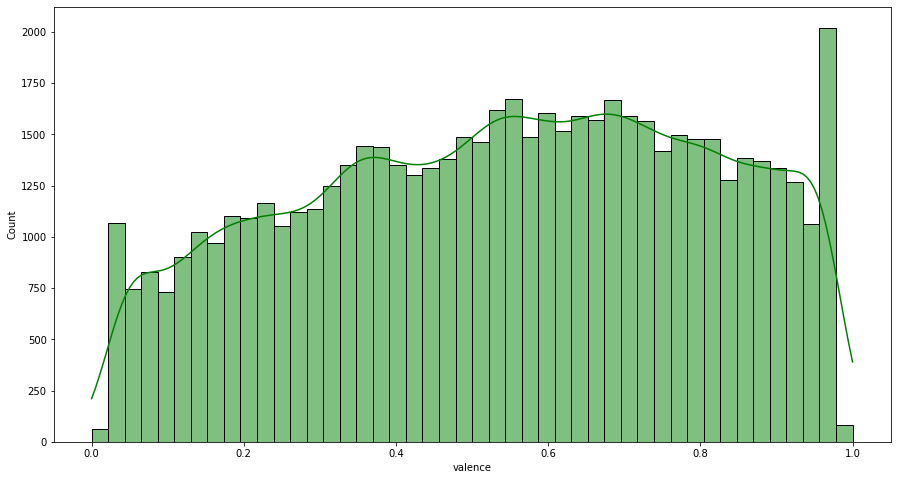

In [27]:
plt.figure(figsize=(15,8))
sns.histplot(x='valence', data=low_level_tracks_dummies, kde=True, color='g');

* Again, we plot the correlation heatmap for our variables.

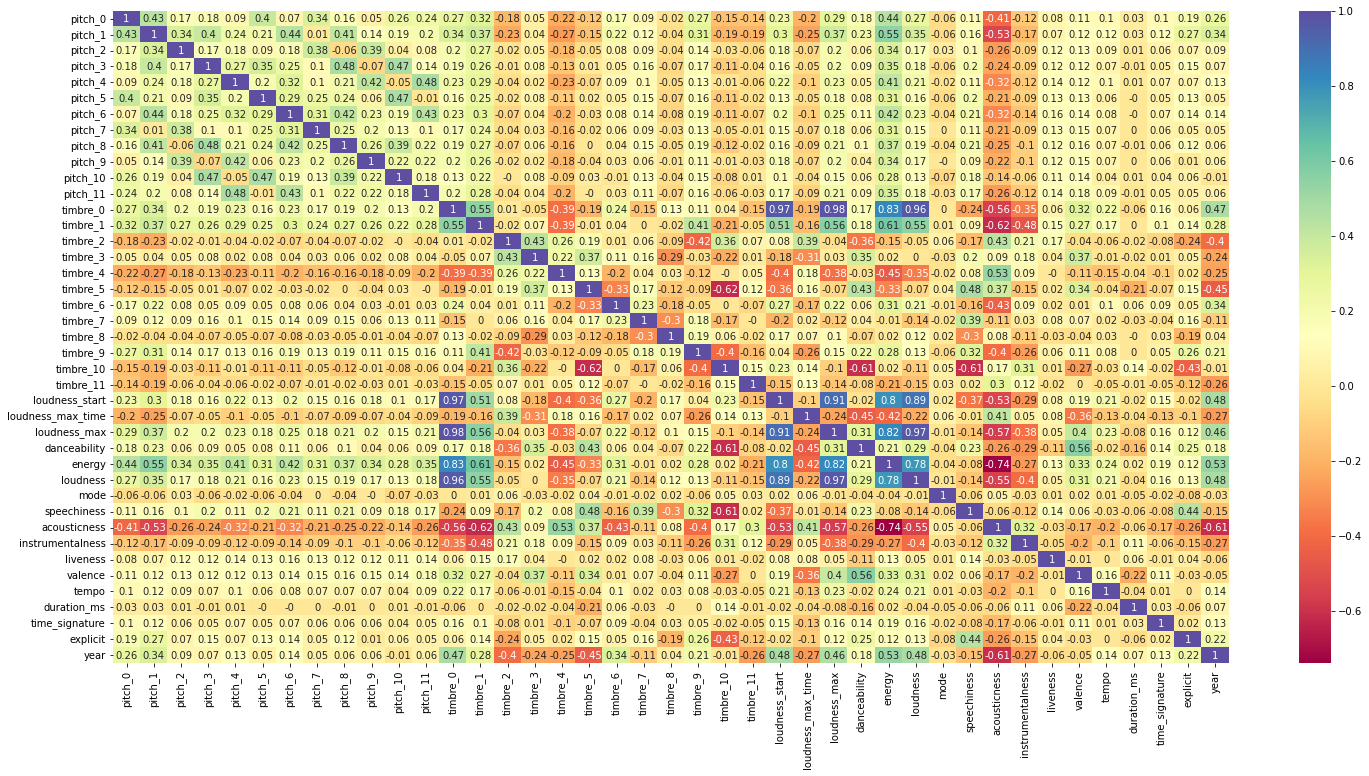

In [28]:
plt.figure(figsize=(25,12))
cor = round(low_level_tracks.loc[:,low_level_tracks.columns != 'key'].corr(),2)
sns.heatmap(cor, annot=True, cmap="Spectral")
plt.show()

* For the valence we notice that:
    * *Valence*, except *danceability* and *energy*, seems to be correlated with some of the pitch, timbre and loudness variables that was introduced. 
* For the other variables we notice that:
    * *Loudness* is highly positive correlated with *timbre_0* and all the other loudness variables, except *loudness_max_time*.
    *  Also there are some correlations between the timbre variables and similarly between the pitch variables.


* Next, we plot the pitch variables with the valence.
* We can see that all, in some extent, indicate the same positive correlation.

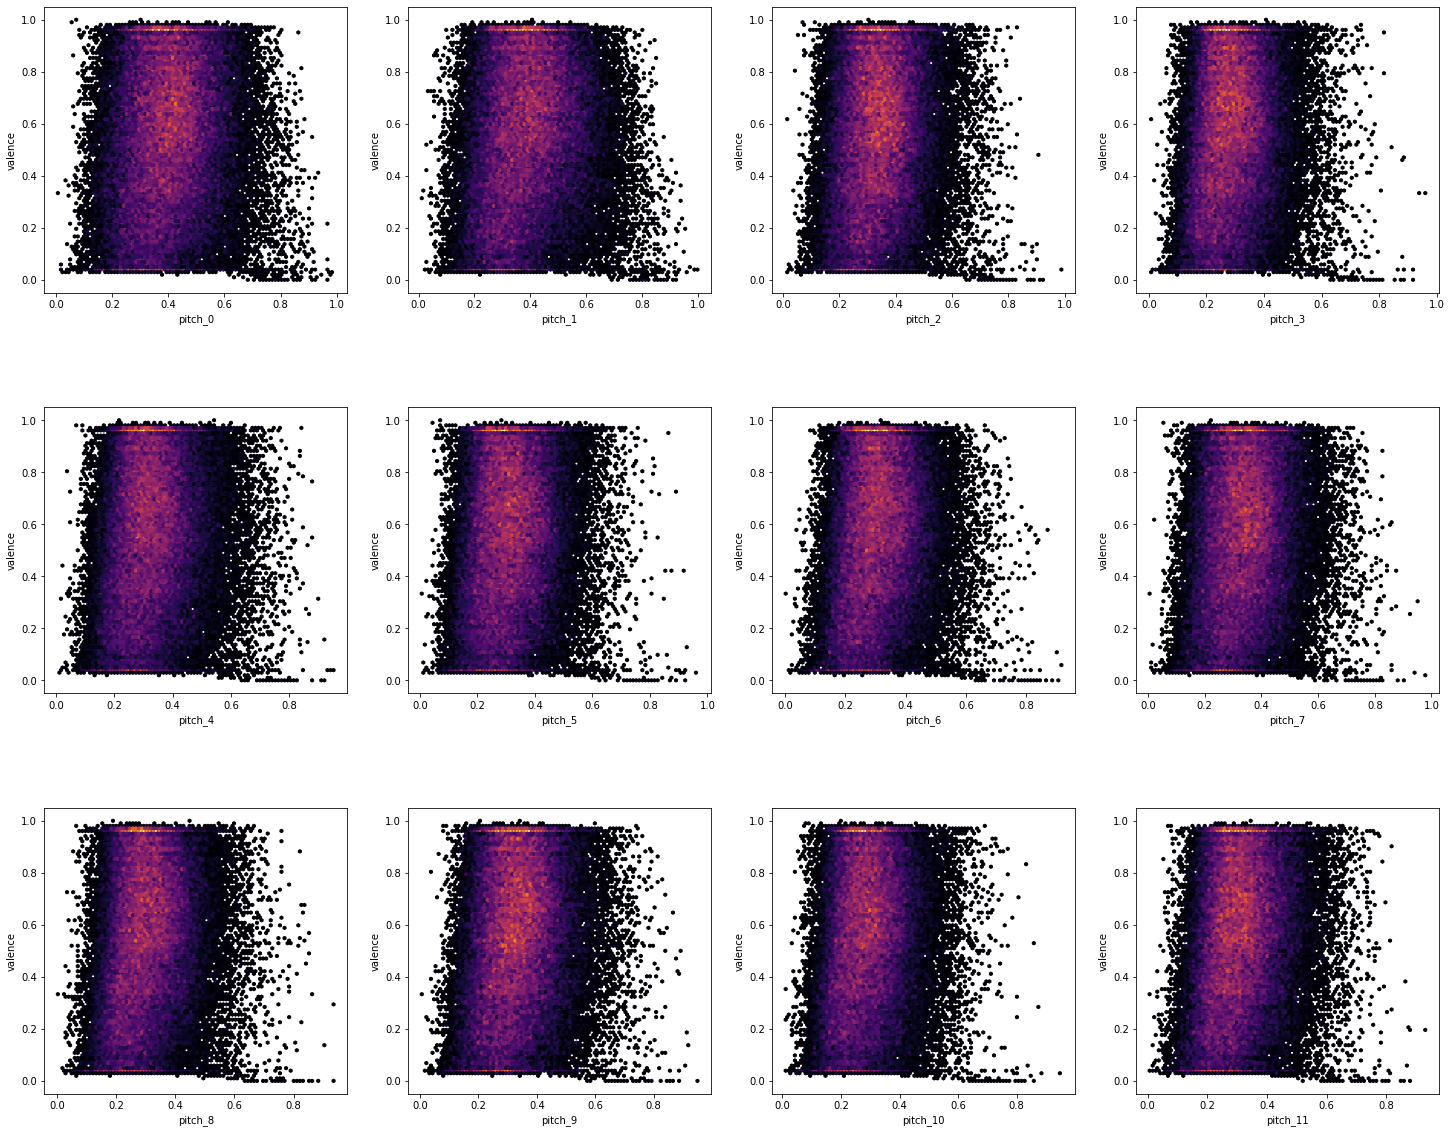

In [29]:
pitch_attributes = list(low_level_tracks_dummies.columns[0:12])

plt.figure(figsize=(25, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(len(pitch_attributes)):
  plt.subplot(3, 4, i + 1)
  plt.hexbin(low_level_tracks_dummies[pitch_attributes[i]], y=low_level_tracks_dummies['valence'], gridsize=90, mincnt=1, cmap="inferno")
  plt.xlabel(pitch_attributes[i])
  plt.ylabel('valence')

* We do the same thing for the timbre variables.
* Here we can see that the results are different and each variable has a different correlation with valence.

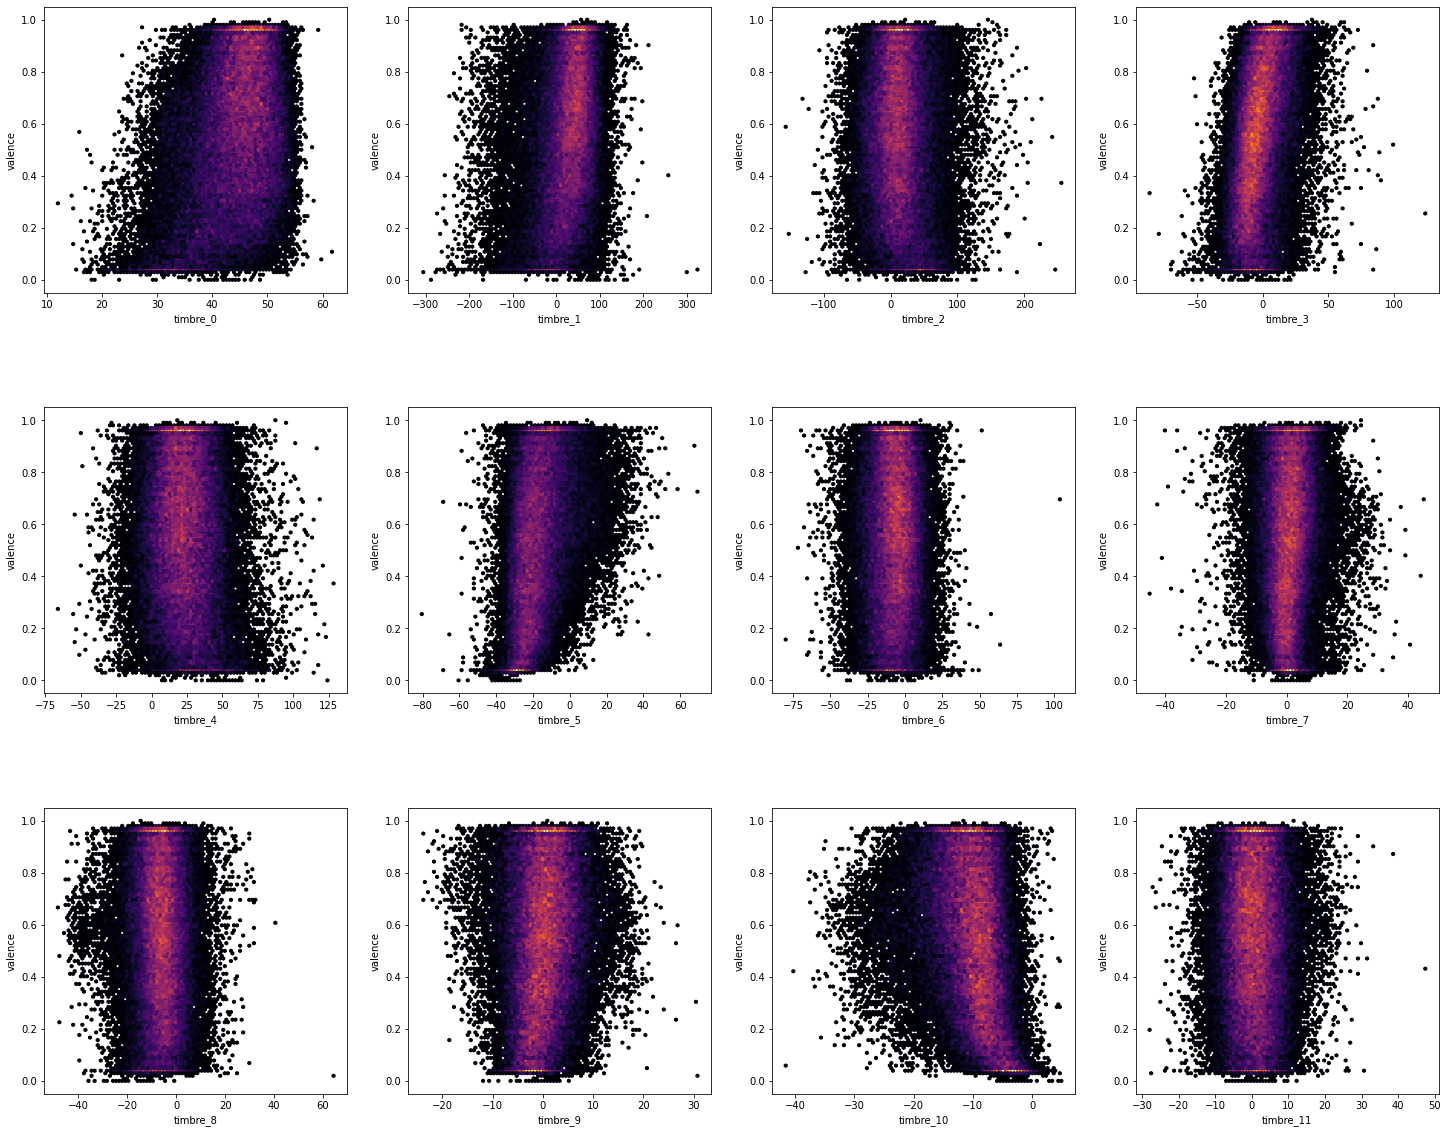

In [30]:
timbre_attributes = list(low_level_tracks_dummies.columns[12:24])

plt.figure(figsize=(25, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(len(timbre_attributes)):
  plt.subplot(3, 4, i + 1)
  plt.hexbin(low_level_tracks_dummies[timbre_attributes[i]], y=low_level_tracks_dummies['valence'], gridsize=90, mincnt=1, cmap="inferno")
  plt.xlabel(timbre_attributes[i])
  plt.ylabel('valence')

* Lastly, we repeat the procedure for the loudness variables.
* We notice that *loudness_max_time* has a slight negative corellation, while the other two variables follow the same positive correlation.

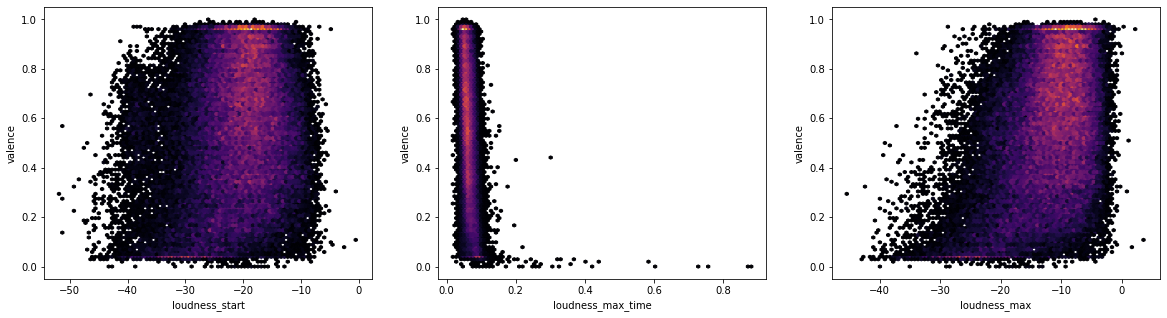

In [31]:
loudness_attributes = list(low_level_tracks_dummies.columns[24:27])

plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.4)

for i in range(len(loudness_attributes)):
  plt.subplot(1, 3, i + 1)
  plt.hexbin(low_level_tracks_dummies[loudness_attributes[i]], y=low_level_tracks_dummies['valence'], gridsize=90, mincnt=1, cmap="inferno")
  plt.xlabel(loudness_attributes[i])
  plt.ylabel('valence')

* We calculate the VIF measures to see if now multicollinearity exists.

In [32]:
C = add_constant(low_level_tracks_dummies.iloc[:, 0:-1])
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const                86683.090155
pitch_0                  3.089589
pitch_1                  3.992668
pitch_2                  2.914308
pitch_3                  3.143134
pitch_4                  3.217793
pitch_5                  2.742951
pitch_6                  2.910170
pitch_7                  2.798204
pitch_8                  2.904193
pitch_9                  3.012463
pitch_10                 3.030629
pitch_11                 2.748931
timbre_0               732.332880
timbre_1                 4.687401
timbre_2                15.189474
timbre_3                13.136691
timbre_4                 2.164695
timbre_5                12.792268
timbre_6                 3.050119
timbre_7                 1.989500
timbre_8                 1.630593
timbre_9                 2.512137
timbre_10                8.205635
timbre_11                1.669762
loudness_start         438.684463
loudness_max_time        2.863508
loudness_max           367.131233
danceability             4.789845
energy        

* We see that by the introduction of the varibales that concern loudness multicollinearity has increased significantly.

* Now, we proceed to the creation of the regression models.
* We follow the same procedure as in the previous section.

In [33]:
best_model_forward, best_models_forward = forward_stepwise_selection(low_level_tracks_std.loc[:,low_level_tracks_std.columns != 'key_0'], 'valence')
print('Best overall model:', len(best_model_forward.model.exog_names), best_model_forward.model.exog_names)

Fitted 1379 models
Best overall model: 49 ['intercept', 'danceability', 'loudness_max', 'loudness', 'year', 'explicit', 'loudness_max_time', 'timbre_5', 'energy', 'speechiness', 'tempo', 'loudness_start', 'timbre_10', 'duration_ms', 'timbre_0', 'timbre_1', 'pitch_1', 'timbre_4', 'pitch_11', 'key_4', 'pitch_8', 'pitch_2', 'timbre_6', 'instrumentalness', 'timbre_2', 'acousticness', 'timbre_11', 'pitch_0', 'key_5', 'pitch_4', 'pitch_5', 'pitch_6', 'timbre_9', 'key_11', 'pitch_3', 'key_2', 'key_6', 'mode', 'key_10', 'time_signature', 'timbre_7', 'key_7', 'pitch_7', 'key_3', 'key_9', 'timbre_8', 'key_1', 'timbre_3', 'pitch_9']


* The best model has 49 variables in total, which are almost all the variables.
* We plot the best model's summary to see which variables are important.

In [34]:
best_model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2066.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:29:19   Log-Likelihood:                -53817.
No. Observations:               58358   AIC:                         1.077e+05
Df Residuals:                   58309   BIC:                         1.082e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -1.831e-15      0.003  -7.27e-13      1.000      -0.005       0.005
danceability          0.2828      0.005     52.557      0.000       0.272       0.293
loudness_max          1.1384      0.048     23.706      0.000       1.044       1.233
loudness             -1.0460      0.012    -87.863      0.000      -1.069      -1.023
year                 -0.1505      0.004    -37.651      0.000      -0.158      -0.143
explicit             -0.0920      0.003    -29.143      0.000      -0.098      -0.086
loudness_max_time    -0.1013      0.004    -23.900      0.000      -0.110      -0.093
timbre_5              0.2257      0.009     25.182      0.000       0.208       0.243
energy                0.2549      0.010     25.776      0.000       0.235       0.274
speechiness          -0.1480      0.005    -31.918      0.000      -0.157      -0.139
tempo                 0.0618      0.003     22.801      0.000       0.056       0.067
loudness_start       -1.2571      0.053    -23.934      0.000      -1.360      -1.154
timbre_10             0.2111      0.007     29.465      0.000       0.197       0.225
duration_ms          -0.0604      0.003    -22.578      0.000      -0.066      -0.055
timbre_0              1.1768      0.068     17.312      0.000       1.044       1.310
timbre_1              0.1217      0.005     22.440      0.000       0.111       0.132
pitch_1              -0.0552      0.005    -11.036      0.000      -0.065      -0.045
timbre_4              0.0461      0.004     12.467      0.000       0.039       0.053
pitch_11              0.0794      0.004     20.287      0.000       0.072       0.087
key_4                -0.0298      0.004     -8.419      0.000      -0.037      -0.023
pitch_8               0.0392      0.004      9.279      0.000       0.031       0.047
pitch_2               0.0385      0.004      9.208      0.000       0.030       0.047
timbre_6              0.0784      0.004     17.909      0.000       0.070       0.087
instrumentalness     -0.0234      0.003     -6.735      0.000      -0.030      -0.017
timbre_2             -0.0521      0.010     -5.319      0.000      -0.071      -0.033
acousticness          0.0807      0.007     11.780      0.000       0.067       0.094
timbre_11            -0.0388      0.003    -11.923      0.000      -0.045      -0.032
pitch_0              -0.0667      0.004    -15.237      0.000      -0.075      -0.058
key_5                 0.0091      0.003      2.855      0.004       0.003       0.015
pitch_4              -0.0274      0.004     -6.932      0.000      -0.035      -0.020
pitch_5               0.0277      0.004      7.094      0.000       0.020       0.035
pitch_6              -0.0205      0.004     -4.819      0.000      -0.029      -0.012
timbre_9              0.0142      0.004      3.564      0.000       0.006

* The best model achieved a 0.63 R-squared, which means that the model explains the 63% of the variation.
* We notice that the variables that are the most important are the ones that describe the loudness.
* *Danceability* looses its dominance, but remains important.
* Moreover, we can see that some timbre and pitch variables are important too.
* All the important variables are statistically significant with p-values < 0.05.

* Next, we try the backward stepwise selection.

In [35]:
best_model_backward, best_models_backward = backward_stepwise_selection(low_level_tracks_std.loc[:,low_level_tracks_std.columns != 'key_0'], 'valence')
print('Best overall model:', len(best_model_backward.model.exog_names), best_model_backward.model.exog_names)

Fitted 1379 models
Best overall model: 49 ['intercept', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'loudness_start', 'loudness_max_time', 'loudness_max', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'duration_ms', 'time_signature', 'explicit', 'year', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_9', 'key_10', 'key_11']


* The best model has 49 variables in total and it's the same as in the forward stepwise selection.
* As a result the summary and the important variables are the same.

In [36]:
best_model_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2066.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:32:29   Log-Likelihood:                -53817.
No. Observations:               58358   AIC:                         1.077e+05
Df Residuals:                   58309   BIC:                         1.082e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          -1.86e-15      0.003  -7.38e-13      1.000      -0.005       0.005
pitch_0              -0.0667      0.004    -15.237      0.000      -0.075      -0.058
pitch_1              -0.0552      0.005    -11.036      0.000      -0.065      -0.045
pitch_2               0.0385      0.004      9.208      0.000       0.030       0.047
pitch_3              -0.0154      0.004     -3.872      0.000      -0.023      -0.008
pitch_4              -0.0274      0.004     -6.932      0.000      -0.035      -0.020
pitch_5               0.0277      0.004      7.094      0.000       0.020       0.035
pitch_6              -0.0205      0.004     -4.819      0.000      -0.029      -0.012
pitch_7               0.0084      0.004      1.996      0.046       0.000       0.017
pitch_8               0.0392      0.004      9.279      0.000       0.031       0.047
pitch_9               0.0056      0.004      1.428      0.153      -0.002       0.013
pitch_11              0.0794      0.004     20.287      0.000       0.072       0.087
timbre_0              1.1768      0.068     17.312      0.000       1.044       1.310
timbre_1              0.1217      0.005     22.440      0.000       0.111       0.132
timbre_2             -0.0521      0.010     -5.319      0.000      -0.071      -0.033
timbre_3             -0.0137      0.009     -1.498      0.134      -0.032       0.004
timbre_4              0.0461      0.004     12.467      0.000       0.039       0.053
timbre_5              0.2257      0.009     25.182      0.000       0.208       0.243
timbre_6              0.0784      0.004     17.909      0.000       0.070       0.087
timbre_7              0.0081      0.004      2.278      0.023       0.001       0.015
timbre_8              0.0055      0.003      1.709      0.088      -0.001       0.012
timbre_9              0.0142      0.004      3.564      0.000       0.006       0.022
timbre_10             0.2111      0.007     29.465      0.000       0.197       0.225
timbre_11            -0.0388      0.003    -11.923      0.000      -0.045      -0.032
loudness_start       -1.2571      0.053    -23.934      0.000      -1.360      -1.154
loudness_max_time    -0.1013      0.004    -23.900      0.000      -0.110      -0.093
loudness_max          1.1384      0.048     23.706      0.000       1.044       1.233
danceability          0.2828      0.005     52.557      0.000       0.272       0.293
energy                0.2549      0.010     25.776      0.000       0.235       0.274
loudness             -1.0460      0.012    -87.863      0.000      -1.069      -1.023
mode                  0.0077      0.003      2.914      0.004       0.003       0.013
speechiness          -0.1480      0.005    -31.918      0.000      -0.157      -0.139
acousticness          0.0807      0.007     11.780      0.000       0.067

* After the creation of the models, we take the selected variables of the best model (same for the two methods) and we create a new DataFrame, in order to proceed with the predictions.

In [37]:
selected_features = best_model_backward.model.exog_names[1:]
selected_features.append('valence')
low_level_tracks_selected = low_level_tracks_dummies[selected_features].copy()
low_level_tracks_selected

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
238ByVSDcz260ewWOEgAQf  0.460020  0.201881  0.240555  0.169500  0.334406   
533Q9BiC93uzp3AnvMNLmc  0.360192  0.385989  0.551523  0.210450  0.270202   
3DytidwwDXv5gZVilj2lO1  0.846527  0.426190  0.288279  0.187522  0.303811   
1Xkpw8X6WVmkditTPZ7YSk  0.259775  0.444462  0.419316  0.237481  0.421523   
49C6EGQhCUSgyADHYvJ7ez  0.348984  0.402577  0.329118  0.272448  0.513416   
...                          ...       ...       ...       ...       ...   
5XgCk8ikjfTx02rgxNULEy  0.179790  0.424339  0.463222  0.172609  0.244581   
5K99RGHiLcXAEgrPvw5x8B  0.283515  0.459829  0.238144  0.115733  0.212125   
1Um0R2yaEzp6EmfUhmWkzc  0.371257  0.360626  0.358172  0.328551  0.216945   
1p3vijWl4pezgUtyCmCVln  0.399122  0.421652  0.236681  0.374762  0.200595   
1ZAO69cQCML5s47SAca93d  0.436568  0.361017  0.293913  0.271132  0.251325   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
238ByVSDcz260ewWOEgAQf  0.346195  0.259822  0.380519  0.182167  0.226228  ...   
533Q9BiC93uzp3AnvMNLmc  0.172840  0.367805  0.393697  0.203855  0.374937  ...   
3DytidwwDXv5gZVilj2lO1  0.432586  0.225100  0.355768  0.215971  0.292785  ...   
1Xkpw8X6WVmkditTPZ7YSk  0.316850  0.162951  0.329795  0.294014  0.365389  ...   
49C6EGQhCUSgyADHYvJ7ez  0.340941  0.331070  0.469664  0.486889  0.565561  ...   
...                          ...       ...       ...       ...       ...  ...   
5XgCk8ikjfTx02rgxNULEy  0.182408  0.344043  0.235784  0.211337  0.425495  ...   
5K99RGHiLcXAEgrPvw5x8B  0.548562  0.185078  0.187220  0.262938  0.482391  ...   
1Um0R2yaEzp6EmfUhmWkzc  0.205512  0.229466  0.449279  0.393903  0.255304  ...   
1p3vijWl4pezgUtyCmCVln  0.232562  0.289443  0.191954  0.392973  0.296376  ...   
1ZAO69cQCML5s47SAca93d  0.305283  0.200392  0.240235  0.275943  0.337315  ...   

                        key_2  key_3  key_4  key_5  key_6  key_7  key_9  \
238ByVSDcz260ewWOEgAQf      0      0      0      0      0      0      0   
533Q9BiC93uzp3AnvMNLmc      0      0      0      0      0      1      0   
3DytidwwDXv5gZVilj2lO1      0      0      0      0      0      0      0   
1Xkpw8X6WVmkditTPZ7YSk      1      0      0      0      0      0      0   
49C6EGQhCUSgyADHYvJ7ez      0      0      0      0      0      0      1   
...                       ...    ...    ...    ...    ...    ...    ...   
5XgCk8ikjfTx02rgxNULEy      1      0      0      0      0      0      0   
5K99RGHiLcXAEgrPvw5x8B      0      0      0      0      0      0      0   
1Um0R2yaEzp6EmfUhmWkzc      0      0      0      0      0      0      0   
1p3vijWl4pezgUtyCmCVln      0      1      0      0      0      0      0   
1ZAO69cQCML5s47SAca93d      0      0      0      0      0      0      0   

                        key_10  key_11  valence  
238ByVSDcz260ewWOEgAQf       0       0   0.4180  
533Q9BiC93uzp3AnvMNLmc       0       0   0.9710  
3DytidwwDXv5gZVilj2lO1       0       0   0.6830  
1Xkpw8X6WVmkditTPZ7YSk       0       0   0.7400  
49C6EGQhCUSgyADHYvJ7ez       0       0   0.8960  
...                        ...     ...      ...  
5XgCk8ikjfTx02rgxNULEy       0       0   0.4310  
5K99RGHiLcXAEgrPvw5x8B       1       0   0.0603  
1Um0R2yaEzp6EmfUhmWkzc       0       0   0.1420  
1p3vijWl4pezgUtyCmCVln       0       0   0.2540  
1ZAO69cQCML5s47SAca93d       1       0   0.1240  

[58358 rows x 49 columns]

* We try to combine the loudness variables to reduce the multicollinearity.
* We perform PCA to the 5 loudness variables and we reduce them to 3. 

In [38]:
co_linear_vars = low_level_tracks_dummies[['timbre_0', 'energy', 'loudness', 'loudness_start', 'loudness_max']].copy()

pca = PCA(n_components=3)
scaler = StandardScaler()

co_linear_vars_std = scaler.fit_transform(co_linear_vars)
co_linear_vars_proj = pca.fit_transform(co_linear_vars_std)

print(f'explained variance ratio: {pca.explained_variance_ratio_.sum()}')
print(f'variable contribution: {pca.components_}')

explained variance ratio: 0.9942505781411421
variable contribution: [[-0.4640114  -0.41251733 -0.45047252 -0.44788038 -0.45934795]
 [-0.16986544  0.90183851 -0.31860368 -0.13174219 -0.19740499]
 [-0.14824931  0.10650902  0.50514755 -0.78054363  0.31977424]]


* We see that with 3 components the 99.4% of the variance is explained.
* We append them to a new DataFrame.

In [39]:
low_level_tracks_selected_pca = low_level_tracks_selected.copy()

co_linear_vars_proj = pd.DataFrame(co_linear_vars_proj, index=low_level_tracks_dummies.index)
low_level_tracks_selected_pca['loudness_pca_0'] = co_linear_vars_proj[0]
low_level_tracks_selected_pca['loudness_pca_1'] = co_linear_vars_proj[1]
low_level_tracks_selected_pca['loudness_pca_2'] = co_linear_vars_proj[2]

low_level_tracks_selected_pca.drop(columns=co_linear_vars.columns, inplace=True)
low_level_tracks_selected_pca

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
238ByVSDcz260ewWOEgAQf  0.460020  0.201881  0.240555  0.169500  0.334406   
533Q9BiC93uzp3AnvMNLmc  0.360192  0.385989  0.551523  0.210450  0.270202   
3DytidwwDXv5gZVilj2lO1  0.846527  0.426190  0.288279  0.187522  0.303811   
1Xkpw8X6WVmkditTPZ7YSk  0.259775  0.444462  0.419316  0.237481  0.421523   
49C6EGQhCUSgyADHYvJ7ez  0.348984  0.402577  0.329118  0.272448  0.513416   
...                          ...       ...       ...       ...       ...   
5XgCk8ikjfTx02rgxNULEy  0.179790  0.424339  0.463222  0.172609  0.244581   
5K99RGHiLcXAEgrPvw5x8B  0.283515  0.459829  0.238144  0.115733  0.212125   
1Um0R2yaEzp6EmfUhmWkzc  0.371257  0.360626  0.358172  0.328551  0.216945   
1p3vijWl4pezgUtyCmCVln  0.399122  0.421652  0.236681  0.374762  0.200595   
1ZAO69cQCML5s47SAca93d  0.436568  0.361017  0.293913  0.271132  0.251325   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
238ByVSDcz260ewWOEgAQf  0.346195  0.259822  0.380519  0.182167  0.226228  ...   
533Q9BiC93uzp3AnvMNLmc  0.172840  0.367805  0.393697  0.203855  0.374937  ...   
3DytidwwDXv5gZVilj2lO1  0.432586  0.225100  0.355768  0.215971  0.292785  ...   
1Xkpw8X6WVmkditTPZ7YSk  0.316850  0.162951  0.329795  0.294014  0.365389  ...   
49C6EGQhCUSgyADHYvJ7ez  0.340941  0.331070  0.469664  0.486889  0.565561  ...   
...                          ...       ...       ...       ...       ...  ...   
5XgCk8ikjfTx02rgxNULEy  0.182408  0.344043  0.235784  0.211337  0.425495  ...   
5K99RGHiLcXAEgrPvw5x8B  0.548562  0.185078  0.187220  0.262938  0.482391  ...   
1Um0R2yaEzp6EmfUhmWkzc  0.205512  0.229466  0.449279  0.393903  0.255304  ...   
1p3vijWl4pezgUtyCmCVln  0.232562  0.289443  0.191954  0.392973  0.296376  ...   
1ZAO69cQCML5s47SAca93d  0.305283  0.200392  0.240235  0.275943  0.337315  ...   

                        key_5  key_6  key_7  key_9  key_10  key_11  valence  \
238ByVSDcz260ewWOEgAQf      0      0      0      0       0       0   0.4180   
533Q9BiC93uzp3AnvMNLmc      0      0      1      0       0       0   0.9710   
3DytidwwDXv5gZVilj2lO1      0      0      0      0       0       0   0.6830   
1Xkpw8X6WVmkditTPZ7YSk      0      0      0      0       0       0   0.7400   
49C6EGQhCUSgyADHYvJ7ez      0      0      0      1       0       0   0.8960   
...                       ...    ...    ...    ...     ...     ...      ...   
5XgCk8ikjfTx02rgxNULEy      0      0      0      0       0       0   0.4310   
5K99RGHiLcXAEgrPvw5x8B      0      0      0      0       1       0   0.0603   
1Um0R2yaEzp6EmfUhmWkzc      0      0      0      0       0       0   0.1420   
1p3vijWl4pezgUtyCmCVln      0      0      0      0       0       0   0.2540   
1ZAO69cQCML5s47SAca93d      0      0      0      0       1       0   0.1240   

                        loudness_pca_0  loudness_pca_1  loudness_pca_2  
238ByVSDcz260ewWOEgAQf        2.321045       -0.409098       -0.240860  
533Q9BiC93uzp3AnvMNLmc       -1.550409       -0.960520        0.214795  
3DytidwwDXv5gZVilj2lO1       -2.138345       -0.029940       -0.124190  
1Xkpw8X6WVmkditTPZ7YSk        1.713187        0.350400       -0.014035  
49C6EGQhCUSgyADHYvJ7ez       -1.675048        0.564406       -0.161626  
...                                ...             ...             ...  
5XgCk8ikjfTx02rgxNULEy        1.658054       -0.464006       -0.588732  
5K99RGHiLcXAEgrPvw5x8B        1.492663       -0.283999       -0.665712  
1Um0R2yaEzp6EmfUhmWkzc        0.635833       -0.876443       -0.141702  
1p3vijWl4pezgUtyCmCVln       -0.480848       -0.154386        0.184754  
1ZAO69cQCML5s47SAca93d        2.310193       -0.508518        0.135408  

[58358 rows x 47 columns]

* We calculate the VIF measures to see if the multicollinearity has been erased.

In [40]:
C = add_constant(low_level_tracks_selected_pca.loc[:, low_level_tracks_selected_pca.columns != 'key_11'])
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const                15479.406890
pitch_0                  2.879290
pitch_1                  3.879825
pitch_2                  2.751708
pitch_3                  2.477699
pitch_4                  2.461858
pitch_5                  2.399080
pitch_6                  2.720966
pitch_7                  2.714359
pitch_8                  2.779558
pitch_9                  2.418587
pitch_11                 2.314214
timbre_1                 4.342261
timbre_2                 9.228538
timbre_3                 6.199057
timbre_4                 2.107117
timbre_5                 9.756157
timbre_6                 2.818641
timbre_7                 1.725884
timbre_8                 1.626227
timbre_9                 2.505975
timbre_10                7.464143
timbre_11                1.608968
loudness_max_time        2.833962
danceability             4.352067
mode                     1.058867
speechiness              3.256315
acousticness             7.227416
instrumentalness         1.890322
tempo         

* We notice that now the multicollinearity is not so strong.
* However, after a lot of trails was found that the models with all the loudness variables lead to better predictions than the models with the three components.
* As a result we will use the selected variables from the best regression model without the PCA. 

## Q2: Predict Valence

* In this section we will create machine learning models to predict the valence metric.
* First, we will use non-neural network methods to perform the predictions.
* Next, we will use different neural networks and we will compare the results.

* We start by creating the input (X) and target (y) sets.

In [41]:
X = low_level_tracks_selected.loc[:, low_level_tracks_selected.columns != 'valence'].copy()
y = low_level_tracks_selected['valence'].copy()

* We split the data to train and test set.
* Specifically we keep a 20% holdout dataset to evaluate our predictions.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### SGD Regressor

* The first model that we use is the SGD Regressor, which is a model that performs linear regression by using the *stohastic gradient descent* method.
* This model needs scaling, so we create a pipeline that first performs standardization and then fits the model.
* Also, we perform GridSearchCV to tune the hyperparameters.
* The different models are evaluated by their cross-validation score.

In [ ]:
param_grid = {
    'sgd__alpha': 10.0 ** -np.arange(2, 7),
    'sgd__loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling'],
}

sgd_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("sgd", SGDRegressor(max_iter=10000, random_state=0))])

sgd_regr = GridSearchCV(sgd_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
sgd_regr.fit(X_train, y_train)

print("Best Params: " + str(sgd_regr.best_params_))
print("Best score: " + str(-sgd_regr.best_score_))

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Params: {'sgd__alpha': 1e-05, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'huber', 'sgd__penalty': 'l1'}
Best score: 0.1279944973969609


* The best model has 0.128 mean absolute error on the cross-validation.
* We evaluate it with the test set.

In [ ]:
y_pred = sgd_regr.predict(X_test)
print('Test Score:', metrics.mean_absolute_error(y_test, y_pred))

Test Score: 0.12883403358275475


* The SGD Regressor achieved **0.129** mean absolute error on the test set.

* Since it's a linear model, we can plot the coefficients to see which variables play an important role in the predictions.
* To accomplish that, we create a helper function.

In [ ]:
def plot_coef_magnitude(model, name):
    coefs = pd.Series(
    model.coef_,
    index=X_train.columns
    )
    colors = coefs.apply(lambda x: 'blue' if x > 0 else 'orange')
    plt.figure(figsize=(15,12))
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.barh(coefs.index, coefs.values, color=colors)
    plt.title('{} model'.format(name))

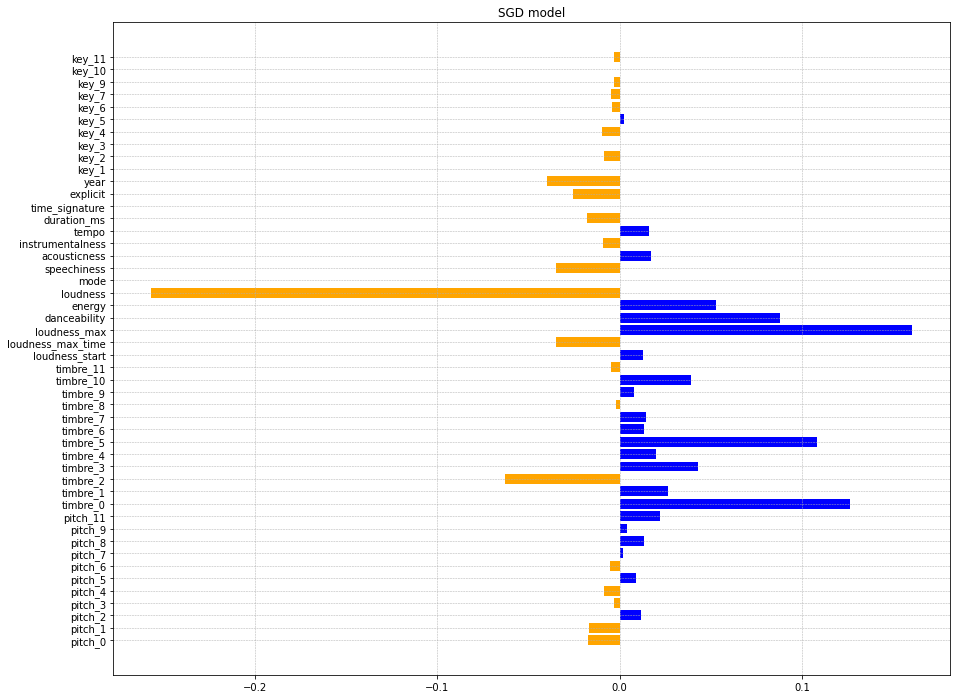

In [ ]:
plot_coef_magnitude(sgd_regr.best_estimator_[1], 'SGD')

* From the coefficient plot we notice that:
    1. The *loudness* attributes are the most dominant.
    2. *Timbre* seems to be important for the predictions.
    3. *Danceability* seems to help in some extent.

### KNeighbors Regressor

* The next model that is being used is the KNeighbors Regressor.
* Again, because we need scaled data, we create a pipeline with a standard scaler and the prediction model.
* The hyperparameter tuning is performed by the GridSearchCV.
* The different models are be evaluated by their cross-validation score.

In [ ]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15, 20, 30],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__weights': ['uniform', 'distance']
}

knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("knn", KNeighborsRegressor())])

knn_regr = GridSearchCV(knn_pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
knn_regr.fit(X_train, y_train)

print("Best Params: " + str(knn_regr.best_params_))
print("Best score: " + str(-knn_regr.best_score_))

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Best score: 0.13780419577916406


* The best model has 0.138 mean absolute error on the cross-validation.
* We evaluate it with the test set.

In [ ]:
y_pred = knn_regr.predict(X_test)
print('Test Score:', metrics.mean_absolute_error(y_test, y_pred))

Test Score: 0.13661286848211684


* The KNeighbors Regressor achieved **0.137** mean absolute error on the test set.

* Since the KNeighbors does not use coefficients and only calculates the nearest points, we cannot interpret which variables matter.

### Decision Trees

* The next category of models that we will use are the decision tress.
* Specifically we will implement three models: Random Forest, XGBoost and LightGBM.

#### Random Forest Regressor

* First we use the Random Forest Regressor.
* Because this model is computationally expensive, instead of exhaustive search, we perform 20 iterations of RandomizedSearchCV.
* The created models are evaluated by their cross-validation score.

In [ ]:
param_grid = {
        'max_depth': [5, 10, 50, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],        
        'n_estimators': [100, 300, 700, 1000]}

random_forest_regr = RandomizedSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=3, n_iter=20, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=0)
random_forest_regr.fit(X_train, y_train)

print("Best Params: " + str(random_forest_regr.best_params_))
print("Best score: " + str(-random_forest_regr.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best score: 0.1188375725162229


* The best model has 0.119 mean absolute error on the cross-validation.
* We evaluate it with the test set.

In [ ]:
y_pred = random_forest_regr.predict(X_test)
print('Test Score:', metrics.mean_absolute_error(y_test, y_pred))

Test Score: 0.11774740951531985


* The Random Forest Regressor achieved **0.118** mean absolute error on the test set.

* We can also plot the feature importances to see which variables play an important role in the predictions.
* To accomplish that, we create a function that first gets and then plots the importances.

In [ ]:
def plot_importances(best_model):
    importances = best_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(15, 10))
    plt.title('Feature importance')

    plt.barh(list(X.columns[indices][::-1]), list(importances[indices][::-1]),
            color='steelblue', height=0.2)
            
    plt.grid()
            
    for i, v in enumerate(list(importances[indices][::-1])):
        plt.text(v+ 0.001, i , str(round(v,2)), color='black')

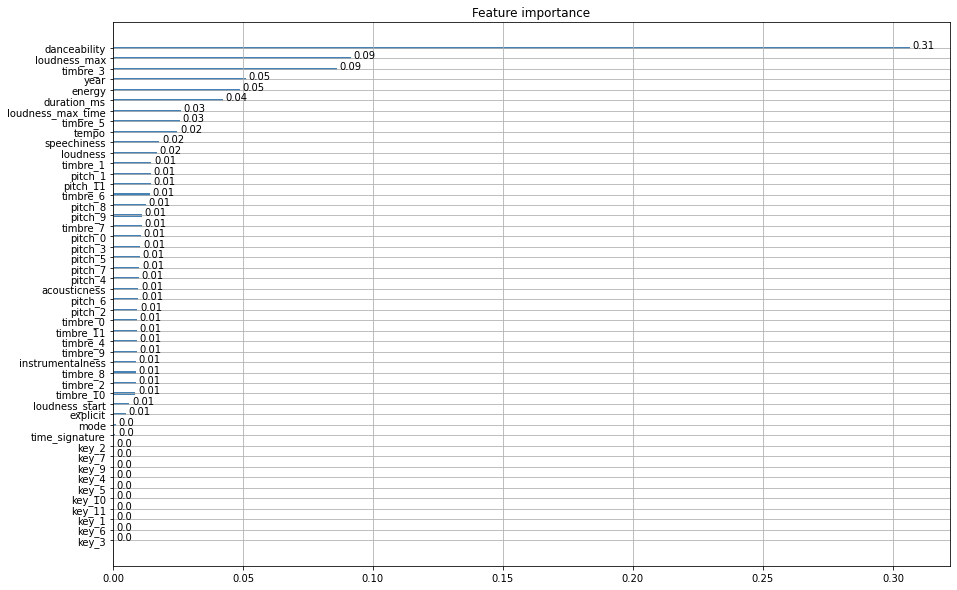

In [ ]:
plot_importances(random_forest_regr.best_estimator_)

* From the feature importances we notice that:
    1. *Danceability* is the most important variable.
    2. The *loudness* variables are also in the top places.
    3. Other important variables seem to be the year and the duration.
 

#### XGBoost Regressor

* The next model is the XGBoost Regressor, which is an efficient implementation of the gradient boosting algorithm.
* Due to computational costs, we tune the hyperparameters with RandomizedSearchCV by doing 300 iterations.
* The different models are evaluated by their cross-validation score.

In [ ]:
param_grid = {
        'max_depth':[3, 6, 8, 10],
        'min_child_weight':[1, 3, 5, 7],
        'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/10.0 for i in range(7,11)],
        'colsample_bytree':[i/10.0 for i in range(7,11)],
        'reg_alpha':[1e-3, 1e-2, 0, 0.1, 1]}

xgb_regr = RandomizedSearchCV(xgb.XGBRegressor(random_state=0), param_grid, cv=3, n_iter=300, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=0)
xgb_regr.fit(X_train, y_train)

print("Best Params: " + str(xgb_regr.best_params_))
print("Best score: " + str(-xgb_regr.best_score_))

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best Params: {'subsample': 0.9, 'reg_alpha': 1, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best score: 0.10763102748422572


* The best model has 0.108 mean absolute error on the cross-validation.
* We evaluate it with the test set.

In [ ]:
y_pred = xgb_regr.predict(X_test)
print('Test Score:', metrics.mean_absolute_error(y_test, y_pred))

Test Score: 0.10706088698517122


* The XGBoost Regressor achieved **0.107** mean absolute error on the test set.

* Like the Random Forest we can plot the feature importances.

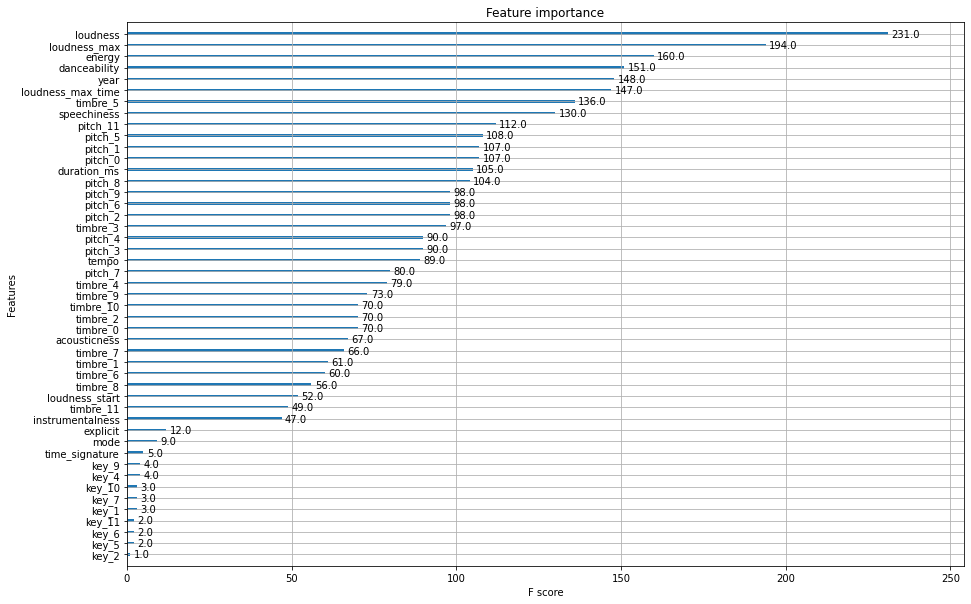

In [ ]:
fig = plt.figure(figsize=(15, 10))
xgb_regr.best_estimator_.get_booster().feature_names = list(X.columns)
xgb.plot_importance(xgb_regr.best_estimator_, ax = fig.gca());

* From the feature importances we notice that: 
    1. This time the *loudness* attributes are the most dominant.
    2. Again, *danceability* and *year* are important.
    3. *Speechiness* seems to be useful in this model.
    4. Lastly, *timbre* and *pitch* variables seem to play an important role as well.

#### LightGBM Regressor

* The last model is be the LightGBM Regressor, which is another implementation of the gradient boosting algorithm.
* As in the previous model we perform RandomizedSearchCV to tune our hyperparameters, however, since this model is much faster we do 3000 iterations.
* The different models are evaluated by their cross-validation score.

In [ ]:
param_grid = {
        'num_leaves': [5, 8, 10, 15, 30], 
        'max_depth': [-1, 3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'reg_alpha':[0, 0.01, 0.05, 1],
        'min_child_samples': [20, 50, 100],
        'min_child_weight': [1e-3, 1e-1, 1, 1e1]}

lgbm_regr = RandomizedSearchCV(lgb.LGBMRegressor(random_state=0), param_grid, cv=3, n_iter=3000, scoring="neg_mean_absolute_error",n_jobs=-1, verbose=1, random_state=0)
lgbm_regr.fit(X_train, y_train)

print("Best Params: " + str(lgbm_regr.best_params_))
print("Best score: " + str(-lgbm_regr.best_score_))

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
Best Params: {'reg_alpha': 1, 'num_leaves': 30, 'min_child_weight': 0.001, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.2}
Best score: 0.10630018798331882


* The best model has 0.106 mean absolute error on the cross-validation.
* We evaluate it with the test set.

In [ ]:
y_pred = lgbm_regr.predict(X_test)
print('Test Score:', metrics.mean_absolute_error(y_test, y_pred))

Test Score: 0.1057830151754155


* The LightGBM Regressor achieved **0.106** mean absolute error on the test set.

* Also, we plot the feature importances to see the important variables.

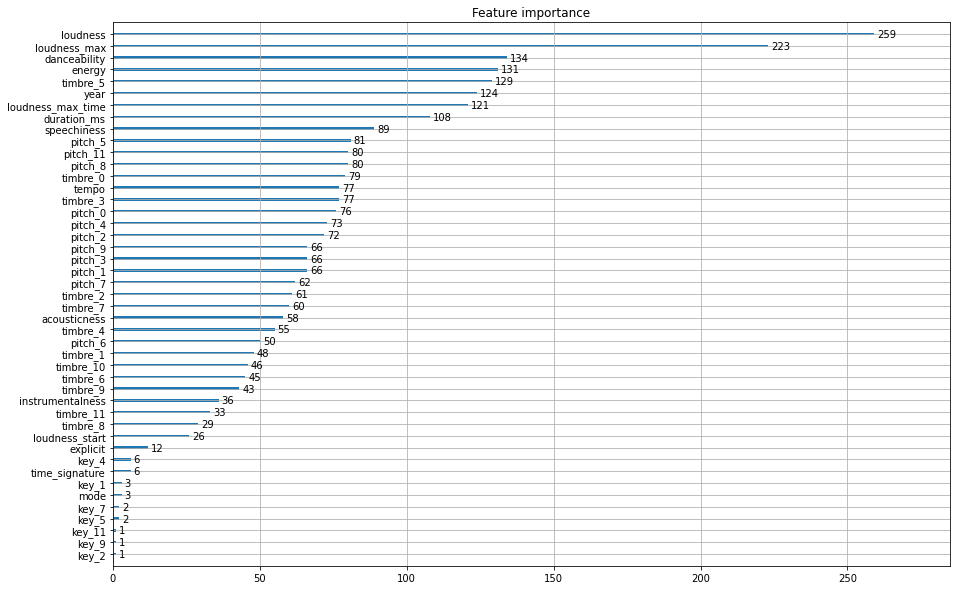

In [ ]:
lgb.plot_importance(lgbm_regr.best_estimator_, figsize=(15, 10), xlabel=None, ylabel=None);

* From the feature importances we notice that:
    1. Like in the XGBoost, *loudness* attributes matter the most.
    2. *Danceability* is in the top places.
    3. *Year* and *duration_ms* are important as well.
    4. *Timbre* and *pitch* seem to be helpful for the predictions.

### Ensemble Models

* After we have created all the non-neural network models we can combine them to get even better predictions.
* For this cause we will get the two best models and use them in a Stacking Regressor.

#### Stacking Regressor

* The two best models are XGBoost and LightGBM. 
* We combine their predictions with a linear regression, in order to get the final.

In [ ]:

estimators = [('xgb', xgb_regr.best_estimator_), ('lgbm', lgbm_regr.best_estimator_)]
final_estimator = LinearRegression()

sreg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

sreg.fit(X_train, y_train)
preds = sreg.predict(X_test)
print('Test Score: ', metrics.mean_absolute_error(y_test, preds))

Test Score:  0.10421112515950967


* We notice that the stacking regressor helped and achieved **0.104** mean absolute error on the test set.

Finally, we can see that the best model for predicting the valence was LightGBM with **0.106** mean absolute error. However, this score can be enhaced by using a Stacking Regressor, which achieved **0.104** mean absolute error.

### Neural Networks

* Now, we will create different neural networks that try to predict the valence.

#### Fully Connected Neural Network

* The first idea is to create a fully connected neural network that takes as input all the X variables.


* We split the train set to train and validation (10%), in order to evaluate the training of the neural networks.

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

* First, we build a normalizer that learns from the train set and will be used in the beginning of the networks to normalize the data.

In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train_nn))
with np.printoptions(precision=2):
    print(normalizer.mean.numpy())
    print(normalizer.variance.numpy())
    print(normalizer.count.numpy())

[[ 4.07e-01  3.99e-01  3.46e-01  2.96e-01  3.37e-01  3.19e-01  3.14e-01
   3.43e-01  3.11e-01  3.40e-01  3.17e-01  4.35e+01  2.03e+01  1.52e+01
  -1.48e+00  2.39e+01 -1.57e+01 -7.28e+00  9.80e-01 -6.33e+00  3.58e-01
  -1.06e+01  8.41e-01 -2.11e+01  6.48e-02 -1.26e+01  5.41e-01  4.94e-01
  -1.13e+01  7.09e-01  1.02e-01  4.88e-01  1.59e-01  1.17e+02  2.36e+05
   3.85e+00  9.13e-02  1.98e+03  7.62e-02  1.13e-01  4.18e-02  7.63e-02
   9.36e-02  5.12e-02  1.22e-01  1.04e-01  7.22e-02  6.34e-02]]
[[1.78e-02 1.88e-02 1.23e-02 1.07e-02 1.37e-02 1.20e-02 1.07e-02 1.27e-02
  1.11e-02 1.27e-02 1.15e-02 4.03e+01 3.04e+03 1.24e+03 2.14e+02 3.42e+02
  1.66e+02 1.53e+02 3.83e+01 6.77e+01 2.57e+01 2.84e+01 3.53e+01 4.74e+01
  2.97e-04 3.89e+01 3.08e-02 7.13e-02 3.12e+01 2.06e-01 2.71e-02 1.42e-01
  9.31e-02 9.37e+02 1.57e+10 2.51e-01 8.30e-02 6.65e+02 7.04e-02 1.00e-01
  4.01e-02 7.05e-02 8.49e-02 4.86e-02 1.07e-01 9.33e-02 6.70e-02 5.94e-02]]
42017


* To find the best neural network architecture we create three different networks, one small sized, one medium sized and one large sized.
* We also use both dropout and the l2 regularizer to avoid overfitting.
* In each layer we use *ReLU* as the activation function and in the output node we will use the *sigmoid* to ensure that the predicted value is between 0 and 1. 
* The presented models have been chosen, after several trials, as the best for each size.

* The small model has one hidden layer with 128 nodes.
* It uses a 0.25 dropout and a 0.0001 regularizer.

In [ ]:
def build_small_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* The medium model has two hidden layer with 128 nodes each.
* It uses 0.3 dropout and 0.0001 regularizers between the layers.

In [ ]:
def build_medium_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* The large model has three hidden layers with 256 nodes, 128 nodes and 64 nodes accordingly.
* It uses 0.3 dropout and 0.0001 regularizers between the layers.

In [ ]:
def build_large_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* Next we create a function that performs the model compilation and the fit.
* It takes as arguments the model, the data, the number of epochs and the batch size.
* All the models use the `InverseTimeDecay` method to adjust the learning rate as the epochs pass.
* Also, they use the `EarlyStopping` callback that stops the model when it starts to overfit or when it cannot perform better.
* Lastly, they use the *mean squared error* as the loss function and the *Adam* optimzer.

In [ ]:
def compile_and_fit(model, X_train, y_train, X_val, y_val, num_epochs, batch_size):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=(len(X_train) // batch_size)*10,
        decay_rate=1,
        staircase=False)
    
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  metrics=['mae'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

    history = model.fit(
        X_train, 
        y_train,
        epochs=num_epochs, 
        validation_data=(X_val, y_val),
        verbose=1,
        batch_size=batch_size,
        callbacks=[early_stop])
    
    return history

* Futhermore, we create a function that diplays the learning curve regarding the mean absolute error.

In [63]:
def plot_loss(history):
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

* Now, we proceed with the model creation and the training.

##### Small Model

In [ ]:
small_model = build_small_model()

In [ ]:
small_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48)               97        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               6272      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,498
Trainable params: 6,401
Non-trainable params: 97
_________________________________________________________________


In [ ]:
history_small = compile_and_fit(small_model, X_train_nn, y_train_nn, X_val_nn, y_val_nn, 500, 16)

Epoch 1/500
2627/2627 [==============================] - 5s 2ms/step - loss: 0.0313 - mae: 0.1272 - val_loss: 0.0234 - val_mae: 0.1117
Epoch 2/500
2627/2627 [==============================] - 4s 2ms/step - loss: 0.0240 - mae: 0.1142 - val_loss: 0.0210 - val_mae: 0.1079
Epoch 3/500
2627/2627 [==============================] - 5s 2ms/step - loss: 0.0225 - mae: 0.1115 - val_loss: 0.0208 - val_mae: 0.1073
Epoch 4/500
2627/2627 [==============================] - 4s 2ms/step - loss: 0.0217 - mae: 0.1098 - val_loss: 0.0196 - val_mae: 0.1048
Epoch 5/500
2627/2627 [==============================] - 4s 2ms/step - loss: 0.0212 - mae: 0.1091 - val_loss: 0.0195 - val_mae: 0.1046
Epoch 6/500
2627/2627 [==============================] - 4s 2ms/step - loss: 0.0208 - mae: 0.1081 - val_loss: 0.0194 - val_mae: 0.1046
Epoch 7/500
2627/2627 [==============================] - 4s 2ms/step - loss: 0.0206 - mae: 0.1077 - val_loss: 0.0195 - val_mae: 0.1055
Epoch 8/500
2627/2627 [==============================] 

In [ ]:
test_loss, test_acc = small_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

365/365 [==============================] - 0s 1ms/step - loss: 0.0166 - mae: 0.0984
Test accuracy: 0.09843534976243973


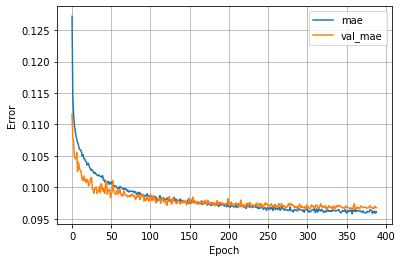

In [ ]:
plot_loss(history_small)

* The small model achieved **0.098** mean absolute error on the test set.

##### Medium Model

In [ ]:
medium_model = build_medium_model()

In [ ]:
medium_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48)               97        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history_medium = compile_and_fit(medium_model, X_train_nn, y_train_nn, X_val_nn, y_val_nn, 500, 32)

Epoch 1/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0430 - mae: 0.1356 - val_loss: 0.0300 - val_mae: 0.1171
Epoch 2/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0290 - mae: 0.1180 - val_loss: 0.0239 - val_mae: 0.1092
Epoch 3/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0249 - mae: 0.1137 - val_loss: 0.0217 - val_mae: 0.1070
Epoch 4/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0230 - mae: 0.1111 - val_loss: 0.0206 - val_mae: 0.1055s: 0.0231 - mae: 0.
Epoch 5/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0222 - mae: 0.1100 - val_loss: 0.0203 - val_mae: 0.1049
Epoch 6/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0219 - mae: 0.1095 - val_loss: 0.0204 - val_mae: 0.1048
Epoch 7/500
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0216 - mae: 0.1087 - val_loss: 0.0198 - val_mae: 0.1045
Epoch 8/500
1314/1314 [=============

In [ ]:
test_loss, test_acc = medium_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

365/365 [==============================] - 0s 1ms/step - loss: 0.0171 - mae: 0.0983
Test accuracy: 0.09833326190710068


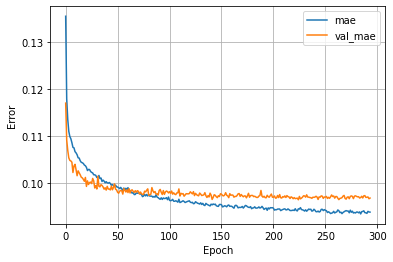

In [ ]:
plot_loss(history_medium)

* The medium model achieved **0.098** mean absolute error on the test set

##### Large Model

In [ ]:
large_model = build_large_model()

In [ ]:
large_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48)               97        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 256)               12544     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
history_large = compile_and_fit(large_model, X_train_nn, y_train_nn, X_val_nn, y_val_nn, 500, 32)

Epoch 1/500
1314/1314 [==============================] - 4s 2ms/step - loss: 0.0498 - mae: 0.1330 - val_loss: 0.0330 - val_mae: 0.1156
Epoch 2/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0303 - mae: 0.1173 - val_loss: 0.0241 - val_mae: 0.1070
Epoch 3/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0254 - mae: 0.1138 - val_loss: 0.0224 - val_mae: 0.1055
Epoch 4/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0238 - mae: 0.1119 - val_loss: 0.0214 - val_mae: 0.1056
Epoch 5/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0231 - mae: 0.1112 - val_loss: 0.0210 - val_mae: 0.1057
Epoch 6/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0226 - mae: 0.1100 - val_loss: 0.0206 - val_mae: 0.1048
Epoch 7/500
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0223 - mae: 0.1095 - val_loss: 0.0206 - val_mae: 0.1047
Epoch 8/500
1314/1314 [==============================] 

In [ ]:
test_loss, test_acc = large_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

365/365 [==============================] - 1s 1ms/step - loss: 0.0178 - mae: 0.0983
Test accuracy: 0.09834908694028854


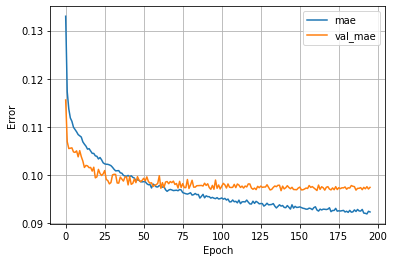

In [ ]:
plot_loss(history_large)

* The large model achieved **0.098** mean absolute error on the test set

We can see that, overall, the fully connected neural networks had better results than the other methods. The best non-neural network model achieved **0.104** mean absolute error on the test set, while all the neural networks achieved **0.098**.

#### Convolutional Neural Network

* Another idea, instead of using the mean values of the low level audio features, is to think the timbre and the pitch as images.
* These attributes are 12 value vectors that change as the segments pass.
* As a result, if we specify a number of segments to use, in this case 150, we can display them as 12x150 images.
* So another approach would be to use convolutional neural networks for the pitch and the timbre and then connect them with the other variables in a dense layer.
* This approach has 3 different inputs, the timbre image, the pitch image and the other normal attributes that we used in the previous models.   

* We load the .npy files, created in the `data_collection.ipynb` notebook, that contain the pitch and timbre vectors downsized to 150 segments per track.

*(These files are also available on Google Drive in the following link: https://drive.google.com/drive/folders/1GgiJTj9JSgNqcbrX5CEBgon_lC-BTvK9?usp=sharing)*

In [43]:
audio_analysis_pitch = np.load('data/pitch_cnn.npy', allow_pickle=True).tolist()
audio_analysis_timbre = np.load('data/timbre_cnn.npy', allow_pickle=True).tolist()

In [44]:
print(len(audio_analysis_pitch), len(audio_analysis_timbre))

59960 59960


* Because some very small tracks has less than 150 segments and some other have been dropped as spoiled, we create an accept list with the tracks we want to keep.

In [45]:
accept_list = []
ids = list(low_level_tracks_dummies.index)

for track_id, a in audio_analysis_pitch.items():
    dim = a.shape[0]
    if (dim == 150) and (track_id in ids):
        accept_list.append(track_id)
        
len(accept_list)

58328

* Also, now we don't want the mean values of the pitch and timbre, so we select the rest of the columns. 

In [46]:
selected_cols = [col for col in X_train.columns if 'pitch_' not in col and 'timbre_' not in col]

* We create a new X train set for the normal variables, that contains only the desired columns and the tracks from the accept list.

In [47]:
X_train_cnn = X_train.loc[X_train.index.isin(accept_list)].copy()
X_train_cnn = X_train_cnn.loc[:,selected_cols]
X_train_cnn

loudness_start  loudness_max_time  loudness_max  \
2KnJ183quw14FCd3Lb3pqL      -27.562228           0.063121    -20.083344   
5hPZdsAI8Jo0mhq5J829Tb      -18.736088           0.079588    -12.052644   
7kYq9F6RyfhtX5FWlwM4gN      -29.800875           0.079185    -17.058621   
0Ogw8HNs1pcGEVt9KfbI4B      -28.647324           0.088302    -22.978776   
2fk9anJ8L2L3mzdJXke7U8      -17.112243           0.076581     -8.077817   
...                                ...                ...           ...   
0GldbAtwBRqjTM1Wo6UCsD      -19.920612           0.073652    -11.837438   
0newQ7hgXeB9bEvqIPS2kr      -15.689624           0.053002     -8.926732   
2HM42m9OHA1kEHbB5j7rDk      -17.246964           0.060130    -10.865884   
2mzBxXdpnB6bL6WWhLYBpc      -16.625925           0.060684     -9.789839   
1e4HGVlCJyLP2ZjfLqqA6B      -18.347950           0.076928    -11.410322   

                        danceability  energy  loudness  mode  speechiness  \
2KnJ183quw14FCd3Lb3pqL         0.429   0.146   -18.769     1       0.0439   
5hPZdsAI8Jo0mhq5J829Tb         0.530   0.305    -8.568     1       0.0280   
7kYq9F6RyfhtX5FWlwM4gN         0.551   0.028   -11.923     1       0.2430   
0Ogw8HNs1pcGEVt9KfbI4B         0.216   0.128   -18.953     0       0.0749   
2fk9anJ8L2L3mzdJXke7U8         0.562   0.562    -6.600     1       0.0425   
...                              ...     ...       ...   ...          ...   
0GldbAtwBRqjTM1Wo6UCsD         0.599   0.614   -11.336     0       0.1180   
0newQ7hgXeB9bEvqIPS2kr         0.583   0.780    -7.986     1       0.0305   
2HM42m9OHA1kEHbB5j7rDk         0.535   0.630    -9.776     1       0.0280   
2mzBxXdpnB6bL6WWhLYBpc         0.638   0.599    -8.190     0       0.0494   
1e4HGVlCJyLP2ZjfLqqA6B         0.332   0.601   -11.025     1       0.0591   

                        acousticness  instrumentalness  ...  key_1  key_2  \
2KnJ183quw14FCd3Lb3pqL        0.9190          0.784000  ...      0      0   
5hPZdsAI8Jo0mhq5J829Tb        0.4920          0.000000  ...      0      0   
7kYq9F6RyfhtX5FWlwM4gN        0.9950          0.019100  ...      0      0   
0Ogw8HNs1pcGEVt9KfbI4B        0.9810          0.000000  ...      0      0   
2fk9anJ8L2L3mzdJXke7U8        0.3310          0.000000  ...      0      0   
...                              ...               ...  ...    ...    ...   
0GldbAtwBRqjTM1Wo6UCsD        0.9890          0.923000  ...      0      0   
0newQ7hgXeB9bEvqIPS2kr        0.0763          0.280000  ...      0      0   
2HM42m9OHA1kEHbB5j7rDk        0.1110          0.000297  ...      1      0   
2mzBxXdpnB6bL6WWhLYBpc        0.0113          0.000000  ...      0      0   
1e4HGVlCJyLP2ZjfLqqA6B        0.7520          0.000000  ...      0      0   

                        key_3  key_4  key_5  key_6  key_7  key_9  key_10  \
2KnJ183quw14FCd3Lb3pqL      0      0      0      0      0      0       0   
5hPZdsAI8Jo0mhq5J829Tb      0      0      0      1      0      0       0   
7kYq9F6RyfhtX5FWlwM4gN      0      0      0      0      0      0       0   
0Ogw8HNs1pcGEVt9KfbI4B      0      0      0      0      0      0       0   
2fk9anJ8L2L3mzdJXke7U8      0      0      0      0      1      0       0   
...                       ...    ...    ...    ...    ...    ...     ...   
0GldbAtwBRqjTM1Wo6UCsD      0      0      1      0      0      0       0   
0newQ7hgXeB9bEvqIPS2kr      0      0      0      0      0      1       0   
2HM42m9OHA1kEHbB5j7rDk      0      0      0      0      0      0       0   
2mzBxXdpnB6bL6WWhLYBpc      0      0      0      0      0      0       0   
1e4HGVlCJyLP2ZjfLqqA6B      0      0      0      0      1      0       0   

                        key_11  
2KnJ183quw14FCd3Lb3pqL       0  
5hPZdsAI8Jo0mhq5J829Tb       0  
7kYq9F6RyfhtX5FWlwM4gN       1  
0Ogw8HNs1pcGEVt9KfbI4B       1  
2fk9anJ8L2L3mzdJXke7U8       0  
...                        ...  
0GldbAtwBRqjTM1Wo6UCsD       0  
0newQ7hgXeB9bEvqIPS2kr       0  
2HM42m9OHA1kEHbB5j7rDk       0  
2mzBxXdpnB6bL6WWhLYBpc       0

* We do the same thing for the X test set.

In [48]:
X_test_cnn = X_test.loc[X_test.index.isin(accept_list)].copy()
X_test_cnn = X_test_cnn.loc[:,selected_cols]
X_test_cnn

loudness_start  loudness_max_time  loudness_max  \
6dK1HEHZcQlh24bSU7pTaZ      -16.552753           0.038724     -5.516828   
2tgUWUgaOdfifOyZaobRib      -24.896652           0.055426    -15.842369   
5qrusoCIMgb9tGtYjBqO4v      -18.301366           0.066350    -11.049586   
4BjJnK4yWGPSP8wR4PpTpT      -29.507580           0.069334    -23.060509   
5LYoHUfjMLd5w7nhVk9Pem      -18.038930           0.068134     -8.421529   
...                                ...                ...           ...   
0HZhYMZOcUzZKSFwPOti6m      -13.822922           0.098865     -7.911373   
3XAmydB9xap3rIFuqgH1VL      -16.861045           0.069641     -9.700582   
2IqPRjJAcLvPqAEbnB2VJz      -16.501358           0.046908     -6.714275   
251nfOQOQYMGiAYTgDJyjp      -33.080942           0.047738    -24.904985   
11c0xkIUPgAa4fnmDPrl8p      -32.385519           0.078720    -22.359801   

                        danceability  energy  loudness  mode  speechiness  \
6dK1HEHZcQlh24bSU7pTaZ         0.778  0.8790    -4.951     0       0.0371   
2tgUWUgaOdfifOyZaobRib         0.759  0.3280   -15.636     1       0.0343   
5qrusoCIMgb9tGtYjBqO4v         0.556  0.4450   -11.477     1       0.0316   
4BjJnK4yWGPSP8wR4PpTpT         0.378  0.2270   -19.285     0       0.0441   
5LYoHUfjMLd5w7nhVk9Pem         0.707  0.4500    -8.895     1       0.0376   
...                              ...     ...       ...   ...          ...   
0HZhYMZOcUzZKSFwPOti6m         0.349  0.3480    -6.142     1       0.0316   
3XAmydB9xap3rIFuqgH1VL         0.450  0.4610    -8.977     1       0.0293   
2IqPRjJAcLvPqAEbnB2VJz         0.765  0.8240    -6.354     1       0.0386   
251nfOQOQYMGiAYTgDJyjp         0.496  0.1080   -23.813     1       0.0318   
11c0xkIUPgAa4fnmDPrl8p         0.541  0.0648   -17.271     0       0.3440   

                        acousticness  instrumentalness  ...  key_1  key_2  \
6dK1HEHZcQlh24bSU7pTaZ        0.3990          0.792000  ...      0      0   
2tgUWUgaOdfifOyZaobRib        0.3860          0.000015  ...      0      1   
5qrusoCIMgb9tGtYjBqO4v        0.6300          0.000000  ...      0      0   
4BjJnK4yWGPSP8wR4PpTpT        0.9500          0.872000  ...      0      0   
5LYoHUfjMLd5w7nhVk9Pem        0.7600          0.000000  ...      0      0   
...                              ...               ...  ...    ...    ...   
0HZhYMZOcUzZKSFwPOti6m        0.7260          0.000000  ...      0      0   
3XAmydB9xap3rIFuqgH1VL        0.7660          0.000000  ...      0      0   
2IqPRjJAcLvPqAEbnB2VJz        0.0436          0.000028  ...      0      0   
251nfOQOQYMGiAYTgDJyjp        0.9880          0.836000  ...      0      0   
11c0xkIUPgAa4fnmDPrl8p        0.8410          0.000004  ...      0      0   

                        key_3  key_4  key_5  key_6  key_7  key_9  key_10  \
6dK1HEHZcQlh24bSU7pTaZ      0      0      0      0      0      0       0   
2tgUWUgaOdfifOyZaobRib      0      0      0      0      0      0       0   
5qrusoCIMgb9tGtYjBqO4v      1      0      0      0      0      0       0   
4BjJnK4yWGPSP8wR4PpTpT      0      0      0      0      1      0       0   
5LYoHUfjMLd5w7nhVk9Pem      0      0      0      0      0      0       1   
...                       ...    ...    ...    ...    ...    ...     ...   
0HZhYMZOcUzZKSFwPOti6m      1      0      0      0      0      0       0   
3XAmydB9xap3rIFuqgH1VL      0      0      0      0      0      0       1   
2IqPRjJAcLvPqAEbnB2VJz      0      0      0      0      0      0       0   
251nfOQOQYMGiAYTgDJyjp      0      0      0      0      0      1       0   
11c0xkIUPgAa4fnmDPrl8p      0      0      0      0      1      0       0   

                        key_11  
6dK1HEHZcQlh24bSU7pTaZ       0  
2tgUWUgaOdfifOyZaobRib       0  
5qrusoCIMgb9tGtYjBqO4v       0  
4BjJnK4yWGPSP8wR4PpTpT       0  
5LYoHUfjMLd5w7nhVk9Pem       0  
...                        ...  
0HZhYMZOcUzZKSFwPOti6m       0  
3XAmydB9xap3rIFuqgH1VL       0  
2IqPRjJAcLvPqAEbnB2VJz       0  
251nfOQOQYMGiAYTgDJyjp       0

* Afterwards, we select the correct targets for the train and the test set.

In [49]:
y_train_cnn = np.array(y_train[X_train_cnn.index])
y_train_cnn

array([0.265, 0.221, 0.559, ..., 0.454, 0.627, 0.413])

In [50]:
y_test_cnn = np.array(y_test[X_test_cnn.index])
y_test_cnn

array([0.942, 0.707, 0.69 , ..., 0.349, 0.368, 0.326])

* It is worth mentioning that the train-test ratio (80-20) remains the same.

* Next, we prepare the timbre and pitch input.
* These vectors are saved in a dictionary where every track has as value an numpy array in the shape (150,12).
* As a result we want to transpose them to (12,150) and then add them in one big numpy array to be used as input.
* We perform this procedure for both the train and the test set.

In [51]:
train_ids_cnn = list(X_train_cnn.index)
timbre_train = np.empty((len(train_ids_cnn), 12, 150))
pitch_train = np.empty((len(train_ids_cnn), 12, 150))

for i in range(len(train_ids_cnn)):
    timbre_train[i] = np.transpose(audio_analysis_timbre[train_ids_cnn[i]])
    pitch_train[i] = np.transpose(audio_analysis_pitch[train_ids_cnn[i]])

In [52]:
test_ids_cnn = list(X_test_cnn.index)
timbre_test = np.empty((len(test_ids_cnn), 12, 150))
pitch_test = np.empty((len(test_ids_cnn), 12, 150))

for i in range(len(test_ids_cnn)):
    timbre_test[i] = np.transpose(audio_analysis_timbre[test_ids_cnn[i]])
    pitch_test[i] = np.transpose(audio_analysis_pitch[test_ids_cnn[i]])

* Now we can plot the timbre and pitch images with the help of the visualization package for music, `librosa`. 

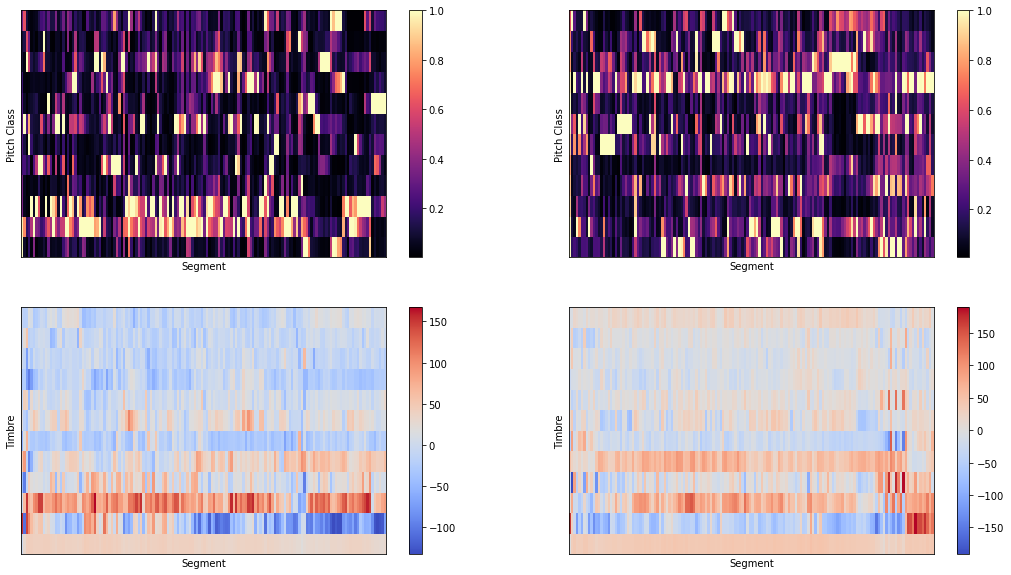

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(18,10))

ax = axs[0,0]
img1= librosa.display.specshow(pitch_train[0], ax=ax)
fig.colorbar(img1, ax=ax)
ax.set_xlabel('Segment')
ax.set_ylabel('Pitch Class')

ax = axs[0,1]
img2 = librosa.display.specshow(pitch_train[-1], ax=ax)
fig.colorbar(img2, ax=ax)
ax.set_xlabel('Segment')
ax.set_ylabel('Pitch Class')

ax = axs[1,0]
img3 = librosa.display.specshow(timbre_train[0], ax=ax)
fig.colorbar(img3, ax=ax)
ax.set_xlabel('Segment')
ax.set_ylabel('Timbre')

ax = axs[1,1]
img4 = librosa.display.specshow(timbre_train[-1], ax=ax)
fig.colorbar(img4, ax=ax)
ax.set_xlabel('Segment')
ax.set_ylabel('Timbre')

plt.show()

* The last thing that we have to do before the creation of the model is to scale tha data.
* First, we scale the normal variables.

In [54]:
cnn_scaler = StandardScaler()
cnn_scaler.fit(X_train_cnn)

X_train_cnn_std = cnn_scaler.transform(X_train_cnn)
X_train_cnn_std = pd.DataFrame(X_train_cnn_std,columns=X_train_cnn.columns, index=X_train_cnn.index)

X_test_cnn_std = cnn_scaler.transform(X_test_cnn)
X_test_cnn_std = pd.DataFrame(X_test_cnn_std,columns=X_test_cnn.columns, index=X_test_cnn.index)

* Then, we perfrom scaling to the timbre and the pitch images.
* Because these inputs are 2D we cannot use the StandardScaler immediately.
* To tackle this problem, stack overflow's help was used, https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix  

In [55]:
scaler_pitch = StandardScaler()
pitch_train_std = scaler_pitch.fit_transform(pitch_train.reshape(-1, pitch_train.shape[-1])).reshape(pitch_train.shape)
pitch_test_std = scaler_pitch.transform(pitch_test.reshape(-1, pitch_test.shape[-1])).reshape(pitch_test.shape)

In [56]:
scaler_timbre = StandardScaler()
timbre_train_std = scaler_timbre.fit_transform(timbre_train.reshape(-1, timbre_train.shape[-1])).reshape(timbre_train.shape)
timbre_test_std = scaler_timbre.transform(timbre_test.reshape(-1, timbre_test.shape[-1])).reshape(timbre_test.shape)

* Now it is time to create the model.
* The architecture consists of three models, the timbre model, the pitch model and the fully connected model.

* The pitch and the timbre models are the same.
* They consist of three convolutional layers that have  3x3 filters, same padding and *ReLU* as the activation function.
* The convolutions have an increased number of channels 16, 32, 64. 
* Also, there are max pooling layers that diminish the dimensions to the half.
* In the end, we have a global average pooling layer that shrinks each channel to one value.

* After the CNNs have completed their task, their output is combined with the normal variables into a fully connected layer.
* This layer outputs to the final node that predicts the outcome, with the use of the *sigmoid*, to ensure that it's between 0 and 1. 

In [57]:
conv_model_pitch = models.Sequential()
conv_model_pitch.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
conv_model_pitch.add(layers.MaxPooling2D((2, 2)))
conv_model_pitch.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
conv_model_pitch.add(layers.MaxPooling2D((2, 2)))
conv_model_pitch.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model_pitch.add(layers.GlobalAveragePooling2D())
conv_model_pitch.add(layers.Dropout(0.25))
conv_model_pitch.add(layers.Flatten())

conv_model_timbre = models.Sequential()
conv_model_timbre.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
conv_model_timbre.add(layers.MaxPooling2D((2, 2)))
conv_model_timbre.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
conv_model_timbre.add(layers.MaxPooling2D((2, 2)))
conv_model_timbre.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model_timbre.add(layers.GlobalAveragePooling2D())
conv_model_timbre.add(layers.Dropout(0.25))
conv_model_timbre.add(layers.Flatten())

fc_model = models.Sequential()
fc_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
fc_model.add(layers.Dropout(0.2))
fc_model.add(layers.Dense(1, activation='sigmoid'))

input1 = Input(shape=(12, 150, 1))
input2 = Input(shape=(12, 150, 1))
input3 = Input(shape=(25,))
cnn_output_pitch = conv_model_pitch(input1)
cnn_output_timbre = conv_model_timbre(input2)
merged = layers.Concatenate(axis=1)([cnn_output_pitch, cnn_output_timbre, input3])
output = fc_model(merged)

cnn_model = models.Model([input1, input2, input3], output )

* Here is the summary of the model.

In [58]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 12, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 64)           23296       ['input_1[0][0]']                
                                                                                              

* We can also depict the architecture.

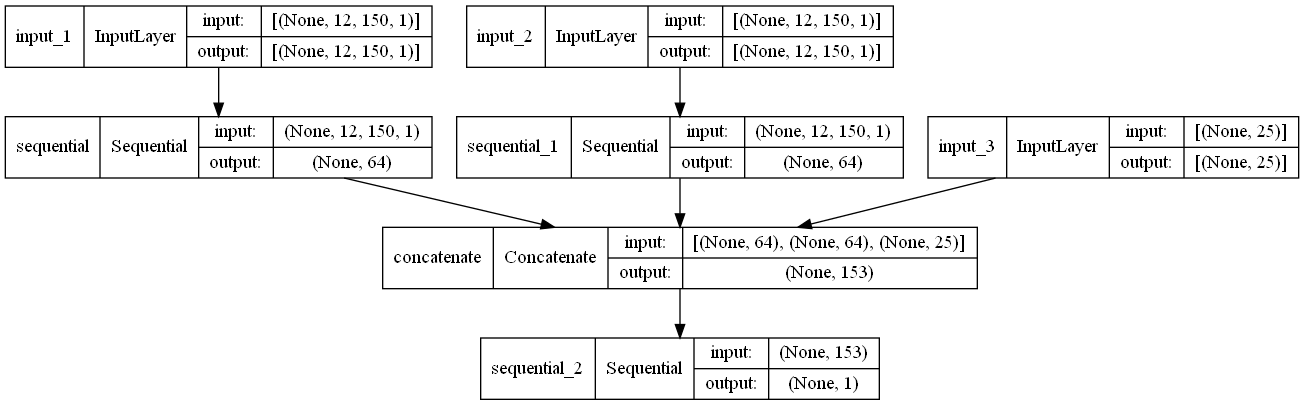

In [59]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

* As in the previous neural networks we use the `InverseTimeDecay` method to tune the learning rate, the *mean_squared_error* as the loss function and the *Adam* optimizer.
* We complie the model.

In [60]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=(len(X_train_cnn) // 64)*10,
        decay_rate=1,
        staircase=False)

cnn_model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  metrics=['mae'])

* We fit the model by using the `EarlyStopping` callback and 64 as batch size.
* We set a 10% validation split.

In [61]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
                              
history = cnn_model.fit([pitch_train_std, timbre_train_std, X_train_cnn_std], y_train_cnn, 
                    epochs=100, 
                    validation_split=0.1,
                    batch_size=64,
                    callbacks=[early_stop])

Epoch 1/100
657/657 [==============================] - 54s 78ms/step - loss: 0.0323 - mae: 0.1290 - val_loss: 0.0237 - val_mae: 0.1130
Epoch 2/100
657/657 [==============================] - 49s 75ms/step - loss: 0.0227 - mae: 0.1120 - val_loss: 0.0225 - val_mae: 0.1118ss: 0.0229 -  - ETA: 5 - ETA: 0s - loss: 0.0227 - ma - ETA: 0s - loss: 0.0227 - mae: 0.112
Epoch 3/100
657/657 [==============================] - 49s 74ms/step - loss: 0.0207 - mae: 0.1080 - val_loss: 0.0190 - val_mae: 0.1030
Epoch 4/100
657/657 [==============================] - 49s 74ms/step - loss: 0.0199 - mae: 0.1067 - val_loss: 0.0195 - val_mae: 0.1041
Epoch 5/100
657/657 [==============================] - 52s 79ms/step - loss: 0.0191 - mae: 0.1049 - val_loss: 0.0188 - val_mae: 0.1014
Epoch 6/100
657/657 [==============================] - 49s 75ms/step - loss: 0.0185 - mae: 0.1032 - val_loss: 0.0181 - val_mae: 0.1017
Epoch 7/100
657/657 [==============================] - 49s 75ms/step - loss: 0.0181 - mae: 0.1020 - 

In [62]:
test_loss, test_acc = cnn_model.evaluate([pitch_test_std, timbre_test_std, X_test_cnn_std], y_test_cnn)

print('Test accuracy:', test_acc)

365/365 [==============================] - 11s 29ms/step - loss: 0.0147 - mae: 0.0915
Test accuracy: 0.09145069122314453


* The convolutional model achieved **0.091** mean absolute error on the test set.

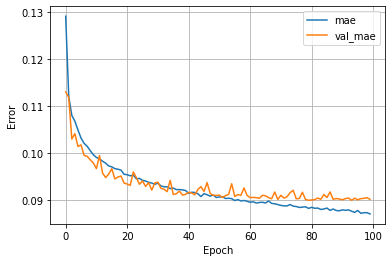

In [64]:
plot_loss(history)

Overall, from all the different machine learning models,we see that the Convolutional Neural Network had the best performance by achieving **0.091** mean absolute error on the test set.

Also, we notice that the neural networks proved to be better for predicting Spotify's valence.

## Final Evaluation

* After we have created all the models it is time to test the best model with the final evaluation data set.

* We import the evaluation data that we collected in the `data_collection.ipynb` notebook.

In [65]:
low_level_tracks_eval = pd.read_csv('data/low_level_tracks_eval.csv',index_col=0)
low_level_tracks_eval

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
7lPN2DXiMsVn7XUKtOW1CS  0.349608  0.367562  0.381938  0.333165  0.233992   
5QO79kh1waicV47BqGRL3g  0.509999  0.369865  0.293584  0.260545  0.470775   
0VjIjW4GlUZAMYd2vXMi3b  0.657973  0.627336  0.334794  0.341640  0.292579   
4MzXwWMhyBbmu6hOcLVD49  0.533442  0.548317  0.340552  0.299635  0.430683   
5Kskr9LcNYa0tpt5f0ZEJx  0.428253  0.406315  0.398415  0.222132  0.477949   
...                          ...       ...       ...       ...       ...   
4lUmnwRybYH7mMzf16xB0y  0.561508  0.683205  0.419908  0.403616  0.429285   
1fzf9Aad4y1RWrmwosAK5y  0.327824  0.477446  0.236671  0.310013  0.575318   
3E3pb3qH11iny6TFDJvsg5  0.511021  0.497643  0.347654  0.238971  0.327831   
3yTkoTuiKRGL2VAlQd7xsC  0.663608  0.480316  0.348203  0.273951  0.353918   
4JE6agBLHGA5TaF6FlqfBD  0.305310  0.299019  0.430959  0.433306  0.222903   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
7lPN2DXiMsVn7XUKtOW1CS  0.421520  0.217720  0.279433  0.162397  0.243067  ...   
5QO79kh1waicV47BqGRL3g  0.272121  0.243054  0.378965  0.232045  0.332873  ...   
0VjIjW4GlUZAMYd2vXMi3b  0.488248  0.285965  0.315812  0.264716  0.234030  ...   
4MzXwWMhyBbmu6hOcLVD49  0.286694  0.319173  0.355134  0.270570  0.365329  ...   
5Kskr9LcNYa0tpt5f0ZEJx  0.250945  0.362671  0.211838  0.106474  0.132667  ...   
...                          ...       ...       ...       ...       ...  ...   
4lUmnwRybYH7mMzf16xB0y  0.359302  0.275779  0.266855  0.178643  0.214506  ...   
1fzf9Aad4y1RWrmwosAK5y  0.267171  0.362626  0.286104  0.506351  0.591351  ...   
3E3pb3qH11iny6TFDJvsg5  0.325581  0.199572  0.265358  0.228669  0.443037  ...   
3yTkoTuiKRGL2VAlQd7xsC  0.437275  0.351312  0.498068  0.301556  0.348925  ...   
4JE6agBLHGA5TaF6FlqfBD  0.279012  0.219432  0.210060  0.146138  0.220564  ...   

                        speechiness  acousticness  instrumentalness  liveness  \
7lPN2DXiMsVn7XUKtOW1CS       0.0601       0.72100          0.000013    0.1050   
5QO79kh1waicV47BqGRL3g       0.0309       0.02120          0.000012    0.5430   
0VjIjW4GlUZAMYd2vXMi3b       0.0598       0.00146          0.000095    0.0897   
4MzXwWMhyBbmu6hOcLVD49       0.0544       0.40100          0.000052    0.1130   
5Kskr9LcNYa0tpt5f0ZEJx       0.0539       0.45100          0.000001    0.1350   
...                             ...           ...               ...       ...   
4lUmnwRybYH7mMzf16xB0y       0.3370       0.13800          0.000000    0.1400   
1fzf9Aad4y1RWrmwosAK5y       0.0318       0.16800          0.002020    0.0465   
3E3pb3qH11iny6TFDJvsg5       0.2670       0.17900          0.000000    0.1940   
3yTkoTuiKRGL2VAlQd7xsC       0.0790       0.05580          0.000000    0.0663   
4JE6agBLHGA5TaF6FlqfBD       0.0340       0.36500          0.004640    0.2200   

                        valence    tempo  duration_ms  time_signature  \
7lPN2DXiMsVn7XUKtOW1CS    0.132  143.874       242014               4   
5QO79kh1waicV47BqGRL3g    0.644  118.051       215627               4   
0VjIjW4GlUZAMYd2vXMi3b    0.334  171.005       200040               4   
4MzXwWMhyBbmu6hOcLVD49    0.145  109.928       205090               4   
5Kskr9LcNYa0tpt5f0ZEJx    0.202  104.949       205458               4   
...                         ...      ...          ...             ...   
4lUmnwRybYH7mMzf16xB0y    0.188  133.997       257428               4   
1fzf9Aad4y1RWrmwosAK5y    0.768   93.003       187310               4   
3E3pb3qH11iny6TFDJvsg5    0.316   83.000       209299               4   
3yTkoTuiKRGL2VAlQd7xsC    0.484  104.973       202204               4   
4JE6agBLHGA5TaF6FlqfBD    0.180  123.829       218755               4   

                        explicit  year  
7lPN2DXiMsVn7XUKtOW1CS         1  2021  
5QO79kh1waicV47BqGRL3g         1  2020  
0VjIjW4GlUZAMYd2vXMi3b         0  2020  
4MzXwWMhyBbmu6hOcLVD49         1  2020  
5Kskr9LcNYa0tpt5f0ZEJx         1  2021  
...                          ...   ...  
4l

* We perform all the proper transformations, as we did before, to make the input ready for evaluation.

In [66]:
key_dummies = dummies = pd.get_dummies(data=low_level_tracks_eval['key'])
key_dummies = key_dummies.add_prefix('key_')

low_level_tracks_dummies_eval = low_level_tracks_eval.join(key_dummies)
low_level_tracks_dummies_eval.drop(columns='key',inplace=True)
low_level_tracks_dummies_eval

pitch_0   pitch_1   pitch_2   pitch_3   pitch_4  \
7lPN2DXiMsVn7XUKtOW1CS  0.349608  0.367562  0.381938  0.333165  0.233992   
5QO79kh1waicV47BqGRL3g  0.509999  0.369865  0.293584  0.260545  0.470775   
0VjIjW4GlUZAMYd2vXMi3b  0.657973  0.627336  0.334794  0.341640  0.292579   
4MzXwWMhyBbmu6hOcLVD49  0.533442  0.548317  0.340552  0.299635  0.430683   
5Kskr9LcNYa0tpt5f0ZEJx  0.428253  0.406315  0.398415  0.222132  0.477949   
...                          ...       ...       ...       ...       ...   
4lUmnwRybYH7mMzf16xB0y  0.561508  0.683205  0.419908  0.403616  0.429285   
1fzf9Aad4y1RWrmwosAK5y  0.327824  0.477446  0.236671  0.310013  0.575318   
3E3pb3qH11iny6TFDJvsg5  0.511021  0.497643  0.347654  0.238971  0.327831   
3yTkoTuiKRGL2VAlQd7xsC  0.663608  0.480316  0.348203  0.273951  0.353918   
4JE6agBLHGA5TaF6FlqfBD  0.305310  0.299019  0.430959  0.433306  0.222903   

                         pitch_5   pitch_6   pitch_7   pitch_8   pitch_9  ...  \
7lPN2DXiMsVn7XUKtOW1CS  0.421520  0.217720  0.279433  0.162397  0.243067  ...   
5QO79kh1waicV47BqGRL3g  0.272121  0.243054  0.378965  0.232045  0.332873  ...   
0VjIjW4GlUZAMYd2vXMi3b  0.488248  0.285965  0.315812  0.264716  0.234030  ...   
4MzXwWMhyBbmu6hOcLVD49  0.286694  0.319173  0.355134  0.270570  0.365329  ...   
5Kskr9LcNYa0tpt5f0ZEJx  0.250945  0.362671  0.211838  0.106474  0.132667  ...   
...                          ...       ...       ...       ...       ...  ...   
4lUmnwRybYH7mMzf16xB0y  0.359302  0.275779  0.266855  0.178643  0.214506  ...   
1fzf9Aad4y1RWrmwosAK5y  0.267171  0.362626  0.286104  0.506351  0.591351  ...   
3E3pb3qH11iny6TFDJvsg5  0.325581  0.199572  0.265358  0.228669  0.443037  ...   
3yTkoTuiKRGL2VAlQd7xsC  0.437275  0.351312  0.498068  0.301556  0.348925  ...   
4JE6agBLHGA5TaF6FlqfBD  0.279012  0.219432  0.210060  0.146138  0.220564  ...   

                        key_2  key_3  key_4  key_5  key_6  key_7  key_8  \
7lPN2DXiMsVn7XUKtOW1CS      0      0      0      0      0      0      0   
5QO79kh1waicV47BqGRL3g      0      0      0      0      0      0      0   
0VjIjW4GlUZAMYd2vXMi3b      0      0      0      0      0      0      0   
4MzXwWMhyBbmu6hOcLVD49      0      0      1      0      0      0      0   
5Kskr9LcNYa0tpt5f0ZEJx      0      0      1      0      0      0      0   
...                       ...    ...    ...    ...    ...    ...    ...   
4lUmnwRybYH7mMzf16xB0y      0      0      0      0      0      0      0   
1fzf9Aad4y1RWrmwosAK5y      0      0      1      0      0      0      0   
3E3pb3qH11iny6TFDJvsg5      0      0      0      0      0      0      0   
3yTkoTuiKRGL2VAlQd7xsC      0      0      0      0      0      0      0   
4JE6agBLHGA5TaF6FlqfBD      0      0      0      0      0      0      0   

                        key_9  key_10  key_11  
7lPN2DXiMsVn7XUKtOW1CS      0       1       0  
5QO79kh1waicV47BqGRL3g      0       0       0  
0VjIjW4GlUZAMYd2vXMi3b      0       0       0  
4MzXwWMhyBbmu6hOcLVD49      0       0       0  
5Kskr9LcNYa0tpt5f0ZEJx      0       0       0  
...                       ...     ...     ...  
4lUmnwRybYH7mMzf16xB0y      1       0       0  
1fzf9Aad4y1RWrmwosAK5y      0       0       0  
3E3pb3qH11iny6TFDJvsg5      0       0       0  
3yTkoTuiKRGL2VAlQd7xsC      0       0       0  
4JE6agBLHGA5TaF6FlqfBD      0       1       0  

[1161 rows x 53 columns]

In [67]:
X_cnn_eval = low_level_tracks_dummies_eval.loc[:,selected_cols].copy()
X_cnn_eval_std = cnn_scaler.transform(X_cnn_eval)
X_cnn_eval_std = pd.DataFrame(X_cnn_eval_std, columns=X_cnn_eval.columns, index=X_cnn_eval.index)

In [68]:
y_cnn_eval = np.array(low_level_tracks_dummies_eval['valence'])

In [69]:
# Also available on Google Drive, https://drive.google.com/drive/folders/1GgiJTj9JSgNqcbrX5CEBgon_lC-BTvK9?usp=sharing
audio_analysis_pitch_eval = np.load('data/pitch_eval.npy', allow_pickle=True).tolist()
audio_analysis_timbre_eval = np.load('data/timbre_eval.npy', allow_pickle=True).tolist()

In [70]:
for i in audio_analysis_pitch_eval.keys():
    audio_analysis_timbre_eval[i] = audio_analysis_timbre_eval[i][0:150,]
    audio_analysis_pitch_eval[i] = audio_analysis_pitch_eval[i][0:150,]

In [71]:
eval_ids = list(low_level_tracks_eval.index)
timbre_eval = np.empty((len(eval_ids), 12, 150))
pitch_eval = np.empty((len(eval_ids), 12, 150))

for i in range(len(eval_ids)):
    timbre_eval[i] = np.transpose(audio_analysis_timbre_eval[eval_ids[i]])
    pitch_eval[i] = np.transpose(audio_analysis_pitch_eval[eval_ids[i]])

In [72]:
pitch_eval_std = scaler_pitch.transform(pitch_eval.reshape(-1, pitch_eval.shape[-1])).reshape(pitch_eval.shape)
timbre_eval_std = scaler_timbre.transform(timbre_eval.reshape(-1, timbre_eval.shape[-1])).reshape(timbre_eval.shape)

* We evaluate the model.

In [73]:
test_loss, test_acc = cnn_model.evaluate([pitch_eval_std, timbre_eval_std, X_cnn_eval_std], y_cnn_eval)

print('Test accuracy:', test_acc)

37/37 [==============================] - 0s 10ms/step - loss: 0.0172 - mae: 0.1017
Test accuracy: 0.10167323052883148


The final mean absolute error is: **0.10167323052883148**